Since the last notebook got super messy....... let's start with defining some functions so things are cleaner jeez

I'm gonna run some models and do the metrics on them here

In [2]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util as gu
import plot_util as pu

from scipy.interpolate import interp1d

In [3]:
data_path = '/fast_scratch/atlas_images/v01-45/' 
file = np.load(data_path+'nn_splitdata_w7_2.npz') #REMAKE THIS FILE if you need this again!! 

In [4]:
X_train = file['arr_0']
X_val = file['arr_1']
X_test = file['arr_2']
Y_train = file['arr_3']
Y_val = file['arr_4']
Y_test = file['arr_5']
eta_train = file['arr_6']
eta_val = file['arr_7']
eta_test = file['arr_8']
ET_train = file['arr_9']
ET_val = file['arr_10']
ET_test = file['arr_11']
Pt_train = file['arr_12']
Pt_val = file['arr_13']
Pt_test = file['arr_14']
Eng_train = file['arr_15']
Eng_val = file['arr_16']
Eng_test = file['arr_17']

In [ ]:
#first run a model with only eta and Pt as global vars
X_glob_train_1 = np.stack((np.array(eta_train), np.array(Pt_train)), axis=1)
X_glob_vali_1 = np.stack((np.array(eta_val), np.array(Pt_val)), axis=1)
X_glob_test_1 = np.stack((np.array(eta_test), np.array(Pt_test)), axis=1)

In [5]:
#first run a model with only eta and Pt as global vars
X_glob_train_1 = np.stack((np.array(eta_train), np.array(Pt_train)), axis=1)
X_glob_vali_1 = np.stack((np.array(eta_val), np.array(Pt_val)), axis=1)
X_glob_test_1 = np.stack((np.array(eta_test), np.array(Pt_test)), axis=1)

#should have been using the log actually
X_glob_train_3 = np.stack((np.array(eta_train), np.log10(Pt_train)), axis=1)
X_glob_vali_3 = np.stack((np.array(eta_val), np.log10(Pt_val)), axis=1)
X_glob_test_3 = np.stack((np.array(eta_test), np.log10(Pt_test)), axis=1)

In [6]:
#later one with eta and E
X_glob_train_2 = np.stack((np.array(eta_train), np.array(Eng_train)), axis=1)
X_glob_vali_2 = np.stack((np.array(eta_val), np.array(Eng_val)), axis=1)
X_glob_test_2 = np.stack((np.array(eta_test), np.array(Eng_test)), axis=1)

#same here
X_glob_train_4 = np.stack((np.array(eta_train), np.log10(Eng_train)), axis=1)
X_glob_vali_4 = np.stack((np.array(eta_val), np.log10(Eng_val)), axis=1)
X_glob_test_4 = np.stack((np.array(eta_test), np.log10(Eng_test)), axis=1)

Correct me if I'm wrong but I haven't changed the actual X inputs so I don't need to go back and take the log of anything there - just whatever energy/momentum I'm passing to the global features parameter. And testing takes place on X data as well, so the selections I did should be fine for either log or not log I think?? Brain

In [7]:
def GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_tr, X_glob_val, X_glob_te, epochs, batch_size, num_glob, filename, fsize):
    #for now, try all three global features in X_glob okay?! 
    #one function to run the model & create the metrics
    
    Phi_sizes, F_sizes = (100, 100, 128), (fsize, fsize, fsize) #F affects the global features, so try increasing?
    # F initially was (100,100,100)
   
    #concatenate the Xs (needed for global features):
    X_tr = [X_train, X_glob_tr] #will this work?
    X_vali = [X_val, X_glob_val]
    X_te = [X_test, X_glob_te]
    
    #make the model:
    pfn = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, num_global_features =num_glob)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint(data_path+filename, save_best_only=True)
    
    # train model
    history = pfn.fit(X_tr, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_vali, Y_val), verbose=1, callbacks=[callback])
   
    return history

In [8]:
hist1 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_1, X_glob_vali_1, X_glob_test_1, 100, 1000, 2, 'w7_pfn_global_etapt.hdf5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [22]:
hist2 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_2, X_glob_vali_2, X_glob_test_2, 100, 1000, 2, 'w7_pfn_global_etaE.hdf5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [34]:
hist3 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_3, X_glob_vali_3, X_glob_test_3, 100, 1000, 2, 'w7_pfn_global_etalogpt.hdf5', 400)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [35]:
hist4 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_4, X_glob_vali_4, X_glob_test_4, 100, 1000, 2, 'w7_pfn_global_etalogE.hdf5', 400)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [123]:
#with F=200
hist5 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_4, X_glob_vali_4, X_glob_test_4, 100, 1000, 2, 'w7_pfn_global_etalogE_bigF.hdf5')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_28[0][0]              
____________________________________________________________________________________________

In [126]:
#with F = 300
hist6 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_4, X_glob_vali_4, X_glob_test_4, 100, 1000, 2, 'w7_pfn_global_etalogE_bigF300.hdf5', 300)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_35 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_35[0][0]              
____________________________________________________________________________________________

In [ ]:
#with F = 400
hist7 = GlobalModel(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_train_4, X_glob_vali_4, X_glob_test_4, 100, 1000, 2, 'w7_pfn_global_etalogE_bigF400.hdf5', 400)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_42 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_42[0][0]              
____________________________________________________________________________________________

In [36]:
#this is the model with the three global params
model3g = tf.keras.models.load_model(data_path+'w7_pfn_global.hdf5')

#this is the no global params model
model_nog = tf.keras.models.load_model(data_path+'w6_pfn_noglob.hdf5')

#now I've made a model with Pt and eta only
model_pt = tf.keras.models.load_model(data_path+'w7_pfn_global_etapt.hdf5')

#...and one with E and eta only
model_E = tf.keras.models.load_model(data_path+'w7_pfn_global_etaE.hdf5')

#and the log versions of the two:
model_lpt = tf.keras.models.load_model(data_path+'w7_pfn_global_etalogpt.hdf5')
model_lE = tf.keras.models.load_model(data_path+'w7_pfn_global_etalogE.hdf5')

#trying a model with larger F sizes (doubled to 200), try with log E:
model_lE_bigF = tf.keras.models.load_model(data_path+'w7_pfn_global_etalogE_bigF.hdf5')
model_lE_bigF300 = tf.keras.models.load_model(data_path+'w7_pfn_global_etalogE_bigF300.hdf5')
model_lE_bigF400 = tf.keras.models.load_model(data_path+'w7_pfn_global_etalogE_bigF400.hdf5')

In [9]:
def metrics(model, X_te, X_globte, select):
    #make metrics
    X_1, X_2 = X_te, X_globte
    fps = []
    tps = []
    threshss = []
    aucs = []
    for selection in select:
        X_interm = [X_1[selection], X_2[selection]] #YAY got it working!! just had to split it up to make the selection
        preds = model.predict(X_interm, batch_size=1000) 
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])
        
        fps.append(pfn_fp)
        tps.append(pfn_tp)
        threshss.append(threshs)
        
        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs.append(auc)
        print('PFN AUC:', auc)
        
    return fps, tps, aucs

In [10]:
def interp95(fps, tps):
    fg = []
    for i in range(len(fps)):
        fg.append(interp1d(tps[i], 1/fps[i]))

    reg95 = []
    for i in range(len(fg)):
        reg95.append(fg[i](.95))
    return reg95

In [32]:
def plots1(ranges, aucs, aucs_ng, reg95, reg95_ng, rangename='eta', globalpars='eta, Pt, E', logx=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,6])
    if logx:
        ax1.semilogx()
    ax1.set_xlim(0., max(ranges)+.1)
    ax1.plot(ranges, aucs, linewidth=3, c='xkcd:sandstone', marker='o', label='global '+globalpars)
    ax1.plot(ranges, aucs_ng, linewidth=3, c='xkcd:macaroni and cheese', marker='o', label='no global features')
    ax1.set_xlabel('absolute range in '+rangename)
    ax1.set_ylabel('AUC')
    ax1.legend()
    
    if logx:
        ax2.semilogx()
    ax2.semilogy()
    ax2.set_xlim(0., max(ranges)+.1)
    ax2.plot(ranges, reg95, linewidth=3, c='xkcd:dark sand', marker='o', label='global '+globalpars)
    ax2.plot(ranges, reg95_ng, linewidth=3, c='xkcd:pale peach', marker='o', label='no global features')
    ax2.set_xlabel('absolute range in '+rangename)
    ax2.set_ylabel('Rejection at 95% efficiency')
    ax2.legend()

In [12]:
def histplots(history):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
    ax1.set_xlim(0,len(history.history['acc']))
    ax1.plot(history.history['acc'], label='training set', c='xkcd:yellow orange', linewidth=3)
    ax1.plot(history.history['val_acc'], label='test set', c='xkcd:desert', linewidth=3)
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.set_xlim(0,len(history.history['acc']))
    ax2.plot(history.history['loss'], label='training set', c='xkcd:orangey yellow', linewidth=3)
    ax2.plot(history.history['val_loss'], label='test set', c='xkcd:bronze', linewidth=3)
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    ax2.legend()

In [13]:
# define ranges and selections in eta

eta_ranges = np.arange(0., 3.1, .1)+.05

selec_01 = abs(eta_test) < 0.1
selec_02 = (abs(eta_test) >= .1) & (abs(eta_test) < .2)
selec_03 = (abs(eta_test) >= .2) & (abs(eta_test) < .3)
selec_04 = (abs(eta_test) >= .3) & (abs(eta_test) < .4)
selec_05 = (abs(eta_test) >= .4) & (abs(eta_test) < .5)
selec_06 = (abs(eta_test) >= .5) & (abs(eta_test) < .6)
selec_07 = (abs(eta_test) >= .6) & (abs(eta_test) < .7)
selec_08 = (abs(eta_test) >= .7) & (abs(eta_test) < .8)
selec_09 = (abs(eta_test) >= .8) & (abs(eta_test) < .9)
selec_10 = (abs(eta_test) >= .9) & (abs(eta_test) < 1.)
selec_11 = (abs(eta_test) >= 1.) & (abs(eta_test) < 1.1)
selec_12 = (abs(eta_test) >= 1.1) & (abs(eta_test) < 1.2)
selec_13 = (abs(eta_test) >= 1.2) & (abs(eta_test) < 1.3)
selec_14 = (abs(eta_test) >= 1.3) & (abs(eta_test) < 1.4)
selec_15 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 1.5)
selec_16 = (abs(eta_test) >= 1.5) & (abs(eta_test) < 1.6)
selec_17 = (abs(eta_test) >= 1.6) & (abs(eta_test) < 1.7)
selec_18 = (abs(eta_test) >= 1.7) & (abs(eta_test) < 1.8)
selec_19 = (abs(eta_test) >= 1.8) & (abs(eta_test) < 1.9)
selec_20 = (abs(eta_test) >= 1.9) & (abs(eta_test) < 2.)
selec_21 = (abs(eta_test) >= 2.) & (abs(eta_test) < 2.1)
selec_22 = (abs(eta_test) >= 2.1) & (abs(eta_test) < 2.2)
selec_23 = (abs(eta_test) >= 2.2) & (abs(eta_test) < 2.3)
selec_24 = (abs(eta_test) >= 2.3) & (abs(eta_test) < 2.4)
selec_25 = (abs(eta_test) >= 2.4) & (abs(eta_test) < 2.5)
selec_26 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 2.6)
selec_27 = (abs(eta_test) >= 2.6) & (abs(eta_test) < 2.7)
selec_28 = (abs(eta_test) >= 2.7) & (abs(eta_test) < 2.8)
selec_29 = (abs(eta_test) >= 2.8) & (abs(eta_test) < 2.9)
selec_30 = (abs(eta_test) >= 2.9) & (abs(eta_test) < 3.)
selec_all = abs(eta_test) <= 3. 

eta_sel = [selec_01, selec_02, selec_03, selec_04, selec_05, selec_06, selec_07, selec_08, selec_09, selec_10,
              selec_11, selec_12, selec_13, selec_14, selec_15, selec_16, selec_17, selec_18, selec_19, selec_20,
              selec_21, selec_22, selec_23, selec_24, selec_25, selec_26, selec_27, selec_28, selec_29, selec_30,
              selec_all]

In [15]:
#define ranges and selections in ET:

ET_range = np.logspace(np.log10(min(ET_test)), np.log10(max(ET_test)+1), 30)

ET_sel = [abs(ET_test) < ET_range[1]]
for i in range(1, len(ET_range)):
    selec_ = (abs(ET_test) >= ET_range[i-1]) & (abs(ET_test) < ET_range[i])
    ET_sel.append(selec_)

ET_sel.append(abs(ET_test) < ET_range[-1]+1)


In [16]:
#define ranges and selections in Pt:

Pt_range = np.logspace(np.log10(min(Pt_test)), np.log10(max(Pt_test)+1), 30)

Pt_sel = [abs(Pt_test) < Pt_range[1]]
for i in range(1, len(Pt_range)):
    selec_ = (abs(Pt_test) >= Pt_range[i-1]) & (abs(Pt_test) < Pt_range[i])
    Pt_sel.append(selec_)

Pt_sel.append(abs(Pt_test) < Pt_range[-1]+1)


In [17]:
#define ranges and selections in E:

E_range = np.logspace(np.log10(min(Eng_test)), np.log10(max(Eng_test)+1), 30)

E_sel = [abs(Eng_test) < E_range[1]]
for i in range(1, len(E_range)):
    selec_ = (abs(Eng_test) >= E_range[i-1]) & (abs(Eng_test) < E_range[i])
    E_sel.append(selec_)

E_sel.append(abs(Eng_test) < E_range[-1]+1)


In [18]:
#define AUC plotting function that is wary of the type of data its using... but lets have all the selections be 
#the same length as eta_sel so 31

def plothelper(ax, labs, fps, tps, aucs, col, fps_all, tps_all, aucs_all):
    ax.set_xlim(0.,.2)
    ax.set_ylim(.8,1.)
    ax.plot([0, 1], [0, 1], 'k--')
    for i in range(len(labs)):
        ax.plot(fps[i], tps[i], c=col[i], linewidth=3, label=labs[i] + ' AUC = %.3f '%aucs[i])
    ax.plot(fps_all, tps_all, c='b', label='all'+' AUC = %.3f '%aucs_all)
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    ax.legend() 

In [19]:
def AUCplot(rang, fps, tps, auc, rangetype='eta'):
    #rangetype can be 'eta', 'E_T', 'E', or 'Pt'
    if rangetype == 'eta':
        labs1 = ['$\eta$ < .1', '.1 <= $\eta$ < .2', '.2 <= $\eta$ < .3','.3 <= $\eta$ < .4','.4 <= $\eta$ < .5']
        labs2 = ['.5 <= $\eta$ < .6','.6 <= $\eta$ < .7','.7 <= $\eta$ < .8','.8 <= $\eta$ < .9','.9 <= $\eta$ < 1.']
        labs3 = ['1. <= $\eta$ < 1.1','1.1 <= $\eta$ < 1.2','1.2 <= $\eta$ < 1.3','1.3 <= $\eta$ < 1.4','1.4 <= $\eta$ < 1.5']
        labs4 = ['1.5 <= $\eta$ < 1.6','1.6 <= $\eta$ < 1.7','1.7 <= $\eta$ < 1.8','1.8 <= $\eta$ < 1.9','1.9 <= $\eta$ < 2']
        labs5 = ['2. <= $\eta$ < 2.1','2.1 <= $\eta$ < 2.2','2.2 <= $\eta$ < 2.3','2.3 <= $\eta$ < 2.4','2.4 <= $\eta$ < 2.5']
        labs6 = ['2.5 <= $\eta$ < 2.6','2.6 <= $\eta$ < 2.7','2.7 <= $\eta$ < 2.8','2.8 <= $\eta$ < 2.9','2.9 <= $\eta$ < 3.']
    elif rangetype=='E_T':
        labs1 = ['$E_T$ < %.3f'%rang[0], '%.3f <= $E_T$ < %.3f'%(rang[0], rang[1]), '%.3f <= $E_T$ < %.3f'%(rang[1], rang[2]),'%.3f <= $E_T$ < %.3f'%(rang[2], rang[3]),'%.3f <= $E_T$ < %.3f'%(rang[3], rang[4])]
        labs2 = ['%.3f <= $E_T$ < %.3f'%(rang[4], rang[5]), '%.3f <= $E_T$ < %.3f'%(rang[5], rang[6]), '%.3f <= $E_T$ < %.3f'%(rang[6], rang[7]),'%.3f <= $E_T$ < %.3f'%(rang[7], rang[8]),'%.3f <= $E_T$ < %.3f'%(rang[8], rang[9])]
        labs3 = ['%.3f <= $E_T$ < %.3f'%(rang[9], rang[10]), '%.3f <= $E_T$ < %.3f'%(rang[10], rang[11]), '%.3f <= $E_T$ < %.3f'%(rang[11], rang[12]),'%.3f <= $E_T$ < %.3f'%(rang[12], rang[13]),'%.3f <= $E_T$ < %.3f'%(rang[13], rang[14])]
        labs4 = ['%.3f <= $E_T$ < %.3f'%(rang[14], rang[15]), '%.3f <= $E_T$ < %.3f'%(rang[15], rang[16]), '%.3f <= $E_T$ < %.3f'%(rang[16], rang[17]),'%.3f <= $E_T$ < %.3f'%(rang[17], rang[18]),'%.3f <= $E_T$ < %.3f'%(rang[18], rang[19])]
        labs5 = ['%.3f <= $E_T$ < %.3f'%(rang[19], rang[20]), '%.3f <= $E_T$ < %.3f'%(rang[20], rang[21]), '%.3f <= $E_T$ < %.3f'%(rang[21], rang[22]),'%.3f <= $E_T$ < %.3f'%(rang[22], rang[23]),'%.3f <= $E_T$ < %.3f'%(rang[23], rang[24])]
        labs6 = ['%.3f <= $E_T$ < %.3f'%(rang[24], rang[25]), '%.3f <= $E_T$ < %.3f'%(rang[25], rang[26]), '%.3f <= $E_T$ < %.3f'%(rang[26], rang[27]),'%.3f <= $E_T$ < %.3f'%(rang[27], rang[28]),'%.3f <= $E_T$ < %.3f'%(rang[28], rang[29])]
  
    elif rangetype=='Pt':
        labs1 = ['$p_T$ < %.3f'%rang[0], '%.3f <= $p_T$ < %.3f'%(rang[0], rang[1]), '%.3f <= $p_T$ < %.3f'%(rang[1], rang[2]),'%.3f <= $p_T$ < %.3f'%(rang[2], rang[3]),'%.3f <= $p_T$ < %.3f'%(rang[3], rang[4])]
        labs2 = ['%.3f <= $p_T$ < %.3f'%(rang[4], rang[5]), '%.3f <= $p_T$ < %.3f'%(rang[5], rang[6]), '%.3f <= $p_T$ < %.3f'%(rang[6], rang[7]),'%.3f <= $p_T$ < %.3f'%(rang[7], rang[8]),'%.3f <= $p_T$ < %.3f'%(rang[8], rang[9])]
        labs3 = ['%.3f <= $p_T$ < %.3f'%(rang[9], rang[10]), '%.3f <= $p_T$ < %.3f'%(rang[10], rang[11]), '%.3f <= $p_T$ < %.3f'%(rang[11], rang[12]),'%.3f <= $p_T$ < %.3f'%(rang[12], rang[13]),'%.3f <= $p_T$ < %.3f'%(rang[13], rang[14])]
        labs4 = ['%.3f <= $p_T$ < %.3f'%(rang[14], rang[15]), '%.3f <= $p_T$ < %.3f'%(rang[15], rang[16]), '%.3f <= $p_T$ < %.3f'%(rang[16], rang[17]),'%.3f <= $p_T$ < %.3f'%(rang[17], rang[18]),'%.3f <= $p_T$ < %.3f'%(rang[18], rang[19])]
        labs5 = ['%.3f <= $p_T$ < %.3f'%(rang[19], rang[20]), '%.3f <= $p_T$ < %.3f'%(rang[20], rang[21]), '%.3f <= $p_T$ < %.3f'%(rang[21], rang[22]),'%.3f <= $p_T$ < %.3f'%(rang[22], rang[23]),'%.3f <= $p_T$ < %.3f'%(rang[23], rang[24])]
        labs6 = ['%.3f <= $p_T$ < %.3f'%(rang[24], rang[25]), '%.3f <= $p_T$ < %.3f'%(rang[25], rang[26]), '%.3f <= $p_T$ < %.3f'%(rang[26], rang[27]),'%.3f <= $p_T$ < %.3f'%(rang[27], rang[28]),'%.3f <= $p_T$ < %.3f'%(rang[28], rang[29])]
  
    elif rangetype=='E':
        labs1 = ['$E$ < %.3f'%rang[0], '%.3f <= $E$ < %.3f'%(rang[0], rang[1]), '%.3f <= $E$ < %.3f'%(rang[1], rang[2]),'%.3f <= $E$ < %.3f'%(rang[2], rang[3]),'%.3f <= $E$ < %.3f'%(rang[3], rang[4])]
        labs2 = ['%.3f <= $E$ < %.3f'%(rang[4], rang[5]), '%.3f <= $E$ < %.3f'%(rang[5], rang[6]), '%.3f <= $E$ < %.3f'%(rang[6], rang[7]),'%.3f <= $E$ < %.3f'%(rang[7], rang[8]),'%.3f <= $E$ < %.3f'%(rang[8], rang[9])]
        labs3 = ['%.3f <= $E$ < %.3f'%(rang[9], rang[10]), '%.3f <= $E$ < %.3f'%(rang[10], rang[11]), '%.3f <= $E$ < %.3f'%(rang[11], rang[12]),'%.3f <= $E$ < %.3f'%(rang[12], rang[13]),'%.3f <= $E$ < %.3f'%(rang[13], rang[14])]
        labs4 = ['%.3f <= $E$ < %.3f'%(rang[14], rang[15]), '%.3f <= $E$ < %.3f'%(rang[15], rang[16]), '%.3f <= $E$ < %.3f'%(rang[16], rang[17]),'%.3f <= $E$ < %.3f'%(rang[17], rang[18]),'%.3f <= $E$ < %.3f'%(rang[18], rang[19])]
        labs5 = ['%.3f <= $E$ < %.3f'%(rang[19], rang[20]), '%.3f <= $E$ < %.3f'%(rang[20], rang[21]), '%.3f <= $E$ < %.3f'%(rang[21], rang[22]),'%.3f <= $E$ < %.3f'%(rang[22], rang[23]),'%.3f <= $E$ < %.3f'%(rang[23], rang[24])]
        labs6 = ['%.3f <= $E$ < %.3f'%(rang[24], rang[25]), '%.3f <= $E$ < %.3f'%(rang[25], rang[26]), '%.3f <= $E$ < %.3f'%(rang[26], rang[27]),'%.3f <= $E$ < %.3f'%(rang[27], rang[28]),'%.3f <= $E$ < %.3f'%(rang[28], rang[29])]
  
    else:
        print('you broke it')
        
        
    col = ['xkcd:golden brown', 'xkcd:amber', 'xkcd:sandy brown', 'xkcd:grey brown', 'xkcd:pale peach']
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[24,16])

    plothelper(ax1, labs1, fps[:5], tps[:5], auc[:5], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax2, labs2, fps[5:10], tps[5:10], auc[5:10], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax3, labs3, fps[10:15], tps[10:15], auc[10:15], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax4, labs4, fps[15:20], tps[15:20], auc[15:20], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax5, labs5, fps[20:25], tps[20:25], auc[20:25], col, fps[-1], tps[-1], auc[-1])
    plothelper(ax6, labs6, fps[25:30], tps[25:30], auc[25:30], col, fps[-1], tps[-1], auc[-1])
    plt.savefig('./'+rangetype+'_ranges_AUCs')

In [20]:
#make metrics for the no global model, these will be universal
def metrics_ng(X_test, selections):

    fps_ng = []
    tps_ng = []
    aucs_ng = []
    for selection in selections:
        preds = model_nog.predict(X_test[selection], batch_size=1000) 
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])

        fps_ng.append(pfn_fp)
        tps_ng.append(pfn_tp)

        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs_ng.append(auc)
        print('PFN AUC:', auc)
    return fps_ng, tps_ng, aucs_ng

In [21]:
#get all the metrics for the no global features model!
fps_ng_eta, tps_ng_eta, auc_ng_eta = metrics_ng(X_test, eta_sel)
fps_ng_pt, tps_ng_pt, auc_ng_pt = metrics_ng(X_test, Pt_sel)
fps_ng_ET, tps_ng_ET, auc_ng_ET = metrics_ng(X_test, ET_sel)
fps_ng_E, tps_ng_E, auc_ng_E = metrics_ng(X_test, E_sel)

PFN AUC: 0.9778651898737227
PFN AUC: 0.9783127095508898
PFN AUC: 0.9776603622078399
PFN AUC: 0.9797812820026444
PFN AUC: 0.979449381589349
PFN AUC: 0.9785590837379706
PFN AUC: 0.9805161425799649
PFN AUC: 0.9776134554379604
PFN AUC: 0.9767846423784298
PFN AUC: 0.97542219985448
PFN AUC: 0.9779614342721266
PFN AUC: 0.9767863514700542
PFN AUC: 0.9736458480094845
PFN AUC: 0.9621387107755552
PFN AUC: 0.9237134964483031
PFN AUC: 0.9275204564957995
PFN AUC: 0.9486568258249932
PFN AUC: 0.9373450913801015
PFN AUC: 0.9365177841699127
PFN AUC: 0.9383653817384383
PFN AUC: 0.9454547182413561
PFN AUC: 0.9543738511224573
PFN AUC: 0.9509423733142741
PFN AUC: 0.9569621811144445
PFN AUC: 0.9503345998203652
PFN AUC: 0.9681950290147777
PFN AUC: 0.9853137145237781
PFN AUC: 0.9845395528386605
PFN AUC: 0.9850872151952879
PFN AUC: 0.9890729055997511
PFN AUC: 0.9649076352864245
PFN AUC: 0.8293650793650793
PFN AUC: 0.8293650793650793
PFN AUC: 0.8685078756917838
PFN AUC: 0.8339468690702088
PFN AUC: 0.824949069892

In [ ]:
fps_3g_eta, tps_3g_eta, auc_3g_eta = metrics(model_3g, X_test, eta_sel)
fps_3g_pt, tps_3g_pt, auc_3g_pt = metrics(X_test, Pt_sel)
fps_3g_ET, tps_3g_ET, auc_3g_ET = metrics(X_test, ET_sel)
fps_3g_E, tps_3g_E, auc_3g_E = metrics(X_test, E_sel)

In [33]:
fps_pt_eta, tps_pt_eta, auc_pt_eta = metrics(model_pt, X_test, X_glob_test_1, eta_sel)
fps_pt_pt, tps_pt_pt, auc_pt_pt = metrics(model_pt, X_test, X_glob_test_1, Pt_sel)
fps_pt_ET, tps_pt_ET, auc_pt_ET = metrics(model_pt, X_test, X_glob_test_1, ET_sel)
fps_pt_E, tps_pt_E, auc_pt_E = metrics(model_pt, X_test, X_glob_test_1, E_sel)

PFN AUC: 0.9770932036392604
PFN AUC: 0.97781417817662
PFN AUC: 0.9772016035492631
PFN AUC: 0.9788309025461936
PFN AUC: 0.978769026424127
PFN AUC: 0.9775584474448946
PFN AUC: 0.9792104273121082
PFN AUC: 0.9759010797449894
PFN AUC: 0.9757648865110284
PFN AUC: 0.9740472534106916
PFN AUC: 0.9760841817663802
PFN AUC: 0.975641350751718
PFN AUC: 0.9720138485593033
PFN AUC: 0.9593381074301401
PFN AUC: 0.9163476125613318
PFN AUC: 0.9251909035705794
PFN AUC: 0.9478169764036455
PFN AUC: 0.934028284723797
PFN AUC: 0.9333524910075481
PFN AUC: 0.9375939521389619
PFN AUC: 0.9450515462993261
PFN AUC: 0.9531282202210845
PFN AUC: 0.9497037234373447
PFN AUC: 0.9556205236585653
PFN AUC: 0.9500183518456324
PFN AUC: 0.9597288154280784
PFN AUC: 0.9803928422638581
PFN AUC: 0.979488572657318
PFN AUC: 0.9812251135871213
PFN AUC: 0.9846586639371874
PFN AUC: 0.9631786561835016
PFN AUC: 0.8690476190476191
PFN AUC: 0.8690476190476191
PFN AUC: 0.8619625372498936
PFN AUC: 0.813899430740038
PFN AUC: 0.8209897326792983

In [34]:
fps_E_eta, tps_E_eta, auc_E_eta = metrics(model_E, X_test, X_glob_test_2, eta_sel)
fps_E_pt, tps_E_pt, auc_E_pt = metrics(model_E, X_test, X_glob_test_2, Pt_sel)
fps_E_ET, tps_E_ET, auc_E_ET = metrics(model_E, X_test, X_glob_test_2, ET_sel)
fps_E_E, tps_E_E, auc_E_E = metrics(model_E, X_test, X_glob_test_2, E_sel)

PFN AUC: 0.9773331029759952
PFN AUC: 0.9777971429819077
PFN AUC: 0.977735283528131
PFN AUC: 0.9795678615062295
PFN AUC: 0.9786876766453152
PFN AUC: 0.9769499919241202
PFN AUC: 0.9780293085285513
PFN AUC: 0.9759102703439757
PFN AUC: 0.9757428369219543
PFN AUC: 0.9734432283472156
PFN AUC: 0.9760514139344602
PFN AUC: 0.9736992374049078
PFN AUC: 0.9722456487001943
PFN AUC: 0.9584240329861572
PFN AUC: 0.9160647361778431
PFN AUC: 0.9235671738432393
PFN AUC: 0.9487155753106109
PFN AUC: 0.933625459870769
PFN AUC: 0.9313175682636528
PFN AUC: 0.9362607764457538
PFN AUC: 0.943609182314944
PFN AUC: 0.9522917619790078
PFN AUC: 0.9495149420488598
PFN AUC: 0.9541245096014868
PFN AUC: 0.9470914375922378
PFN AUC: 0.9593739853237224
PFN AUC: 0.9805672628593278
PFN AUC: 0.9789498227703797
PFN AUC: 0.9827865296739962
PFN AUC: 0.9843634202275141
PFN AUC: 0.9626517492844407
PFN AUC: 0.8174603174603174
PFN AUC: 0.8174603174603174
PFN AUC: 0.8569071945508726
PFN AUC: 0.8177628083491462
PFN AUC: 0.825970854203

In [37]:
fps_Lpt_eta, tps_Lpt_eta, auc_Lpt_eta = metrics(model_lpt, X_test, X_glob_test_3, eta_sel)
fps_Lpt_pt, tps_Lpt_pt, auc_Lpt_pt = metrics(model_lpt, X_test, X_glob_test_3, Pt_sel)#wait these aren't gonna work
fps_Lpt_ET, tps_Lpt_ET, auc_Lpt_ET = metrics(model_lpt, X_test, X_glob_test_3, ET_sel)#figure out the ranges first
fps_Lpt_E, tps_Lpt_E, auc_Lpt_E = metrics(model_lpt, X_test, X_glob_test_3, E_sel)# actually I'm not sure I would need that???

PFN AUC: 0.9785047206387164
PFN AUC: 0.9780037726957979
PFN AUC: 0.9778879491610447
PFN AUC: 0.9795685104825436
PFN AUC: 0.9796371818053876
PFN AUC: 0.9777790984961443
PFN AUC: 0.9795976133526995
PFN AUC: 0.9759203173396859
PFN AUC: 0.9754877803698379
PFN AUC: 0.9730739069999359
PFN AUC: 0.9762338860291584
PFN AUC: 0.9747537832350831
PFN AUC: 0.9707823405096132
PFN AUC: 0.9605784993727091
PFN AUC: 0.9185147341773994
PFN AUC: 0.9216440728436242
PFN AUC: 0.9477722610366835
PFN AUC: 0.9335659798662951
PFN AUC: 0.931204229964517
PFN AUC: 0.9350583244819285
PFN AUC: 0.9407804698741712
PFN AUC: 0.9507789415983233
PFN AUC: 0.9464982444860578
PFN AUC: 0.9532491001769282
PFN AUC: 0.9457563203099958
PFN AUC: 0.9565523501712948
PFN AUC: 0.9808300529896189
PFN AUC: 0.9797692004443967
PFN AUC: 0.9817644548097149
PFN AUC: 0.9846994765618927
PFN AUC: 0.9623883125460471
PFN AUC: 0.876984126984127
PFN AUC: 0.876984126984127
PFN AUC: 0.8607386121753938
PFN AUC: 0.8248918406072107
PFN AUC: 0.824403379176

In [38]:
fps_LE_eta, tps_LE_eta, auc_LE_eta = metrics(model_lE, X_test, X_glob_test_4, eta_sel)
fps_LE_pt, tps_LE_pt, auc_LE_pt = metrics(model_lE, X_test, X_glob_test_4, Pt_sel)
fps_LE_ET, tps_LE_ET, auc_LE_ET = metrics(model_lE, X_test, X_glob_test_4, ET_sel)
fps_LE_E, tps_LE_E, auc_LE_E = metrics(model_lE, X_test, X_glob_test_4, E_sel)

PFN AUC: 0.9793867290077236
PFN AUC: 0.9784129532741405
PFN AUC: 0.9779699503668657
PFN AUC: 0.9796658105741975
PFN AUC: 0.9792398911304414
PFN AUC: 0.9779016349739089
PFN AUC: 0.978911962844605
PFN AUC: 0.9764381867048462
PFN AUC: 0.9754433049188381
PFN AUC: 0.9744860810355297
PFN AUC: 0.9758464767770807
PFN AUC: 0.975480058436739
PFN AUC: 0.9715325166234257
PFN AUC: 0.9599642386175177
PFN AUC: 0.9170276224908072
PFN AUC: 0.9221111821605423
PFN AUC: 0.946146016438781
PFN AUC: 0.9314175058701544
PFN AUC: 0.9310044167752546
PFN AUC: 0.9339768270305656
PFN AUC: 0.9418446393910732
PFN AUC: 0.9523513876617973
PFN AUC: 0.9476443667719968
PFN AUC: 0.9528665184843295
PFN AUC: 0.9481248297462905
PFN AUC: 0.9584851113848839
PFN AUC: 0.9807877854220052
PFN AUC: 0.9767348791647253
PFN AUC: 0.98044492861168
PFN AUC: 0.9835304863828352
PFN AUC: 0.9624974334027202
PFN AUC: 0.8928571428571428
PFN AUC: 0.8928571428571428
PFN AUC: 0.8621221796509152
PFN AUC: 0.8215028462998103
PFN AUC: 0.81630280784357

In [24]:
fps_LEBF_eta, tps_LEBF_eta, auc_LEBF_eta = metrics(model_lE_bigF, X_test, X_glob_test_4, eta_sel)
fps_LEBF_pt, tps_LEBF_pt, auc_LEBF_pt = metrics(model_lE_bigF, X_test, X_glob_test_4, Pt_sel)
fps_LEBF_ET, tps_LEBF_ET, auc_LEBF_ET = metrics(model_lE_bigF, X_test, X_glob_test_4, ET_sel)
fps_LEBF_E, tps_LEBF_E, auc_LEBF_E = metrics(model_lE_bigF, X_test, X_glob_test_4, E_sel)

PFN AUC: 0.9780353796100985
PFN AUC: 0.9775564908650569
PFN AUC: 0.977256517471522
PFN AUC: 0.9789850112430512
PFN AUC: 0.9796597132840914
PFN AUC: 0.977300309624489
PFN AUC: 0.9785090173212537
PFN AUC: 0.9759794087136237
PFN AUC: 0.9757474838916653
PFN AUC: 0.9732485221329299
PFN AUC: 0.9758803502720409
PFN AUC: 0.975073180027573
PFN AUC: 0.971607704334977
PFN AUC: 0.9598394285273774
PFN AUC: 0.9180483989175782
PFN AUC: 0.9243155825429104
PFN AUC: 0.9478658622053743
PFN AUC: 0.93150731663879
PFN AUC: 0.9306915618613892
PFN AUC: 0.9354342942459763
PFN AUC: 0.9445766156687482
PFN AUC: 0.9524965009992645
PFN AUC: 0.9476702148781699
PFN AUC: 0.9526504799731167
PFN AUC: 0.9482870699076773
PFN AUC: 0.9568550886935103
PFN AUC: 0.9811034545978554
PFN AUC: 0.9806090572271629
PFN AUC: 0.9809413782585974
PFN AUC: 0.9871994117799486
PFN AUC: 0.9625397791789423
PFN AUC: 0.9087301587301587
PFN AUC: 0.9087301587301587
PFN AUC: 0.8651021711366539
PFN AUC: 0.8246755218216318
PFN AUC: 0.819853492923573

In [25]:
fps_LEBF3_eta, tps_LEBF3_eta, auc_LEBF3_eta = metrics(model_lE_bigF300, X_test, X_glob_test_4, eta_sel)
fps_LEBF3_pt, tps_LEBF3_pt, auc_LEBF3_pt = metrics(model_lE_bigF300, X_test, X_glob_test_4, Pt_sel)
fps_LEBF3_ET, tps_LEBF3_ET, auc_LEBF3_ET = metrics(model_lE_bigF300, X_test, X_glob_test_4, ET_sel)
fps_LEBF3_E, tps_LEBF3_E, auc_LEBF3_E = metrics(model_lE_bigF300, X_test, X_glob_test_4, E_sel)

PFN AUC: 0.9784316376045342
PFN AUC: 0.9769065621969356
PFN AUC: 0.9768244204071876
PFN AUC: 0.9795520774751634
PFN AUC: 0.9784627711081417
PFN AUC: 0.9771665868898691
PFN AUC: 0.9786068000832561
PFN AUC: 0.9758279309321473
PFN AUC: 0.9752702194073334
PFN AUC: 0.9730293668454539
PFN AUC: 0.9748802906164941
PFN AUC: 0.9753130188186322
PFN AUC: 0.9720636415181869
PFN AUC: 0.9586561886225319
PFN AUC: 0.9152744517874876
PFN AUC: 0.9218407272102369
PFN AUC: 0.946417025479799
PFN AUC: 0.9318624468138534
PFN AUC: 0.9311220007729668
PFN AUC: 0.9360253641112889
PFN AUC: 0.9425755487916946
PFN AUC: 0.9504790381560472
PFN AUC: 0.9470782187226736
PFN AUC: 0.9512103177013114
PFN AUC: 0.9444005537826681
PFN AUC: 0.9581871849101666
PFN AUC: 0.9795540896457657
PFN AUC: 0.9807754499857501
PFN AUC: 0.9822768289711786
PFN AUC: 0.9841350638749968
PFN AUC: 0.9618569397956751
PFN AUC: 0.9087301587301587
PFN AUC: 0.9087301587301587
PFN AUC: 0.868933588761175
PFN AUC: 0.8174516129032259
PFN AUC: 0.81939372077

In [26]:
fps_LEBF4_eta, tps_LEBF4_eta, auc_LEBF4_eta = metrics(model_lE_bigF400, X_test, X_glob_test_4, eta_sel)
fps_LEBF4_pt, tps_LEBF4_pt, auc_LEBF4_pt = metrics(model_lE_bigF400, X_test, X_glob_test_4, Pt_sel)
fps_LEBF4_ET, tps_LEBF4_ET, auc_LEBF4_ET = metrics(model_lE_bigF400, X_test, X_glob_test_4, ET_sel)
fps_LEBF4_E, tps_LEBF4_E, auc_LEBF4_E = metrics(model_lE_bigF400, X_test, X_glob_test_4, E_sel)

PFN AUC: 0.9776088089031665
PFN AUC: 0.9781508512078914
PFN AUC: 0.9780769104096497
PFN AUC: 0.9791774558978876
PFN AUC: 0.9783850363698081
PFN AUC: 0.9768047413675508
PFN AUC: 0.9795041659894748
PFN AUC: 0.975702938785932
PFN AUC: 0.9753425014220293
PFN AUC: 0.9732849556838388
PFN AUC: 0.975275703361261
PFN AUC: 0.9745593558018044
PFN AUC: 0.9711223346677892
PFN AUC: 0.9610599681954283
PFN AUC: 0.9164804829434894
PFN AUC: 0.9237206517838975
PFN AUC: 0.9479977586941452
PFN AUC: 0.9342982255336397
PFN AUC: 0.9291880382437543
PFN AUC: 0.9353538513541746
PFN AUC: 0.943166473164456
PFN AUC: 0.9519936526513867
PFN AUC: 0.9471898284132896
PFN AUC: 0.9498257440494264
PFN AUC: 0.9443170542525411
PFN AUC: 0.9578458098512423
PFN AUC: 0.9807950975328582
PFN AUC: 0.981546829748636
PFN AUC: 0.9832412501185621
PFN AUC: 0.9864278588271876
PFN AUC: 0.9623557757182407
PFN AUC: 0.8412698412698413
PFN AUC: 0.8412698412698413
PFN AUC: 0.8914963814389102
PFN AUC: 0.8297836812144213
PFN AUC: 0.8245622823421

In [27]:
reg95_ng_eta = interp95(fps_ng_eta, tps_ng_eta)
reg95_ng_Pt = interp95(fps_ng_pt, tps_ng_pt)
reg95_ng_ET = interp95(fps_ng_ET, tps_ng_ET)
reg95_ng_E = interp95(fps_ng_E, tps_ng_E)

<ipython-input-10-b165a60b5f60>:4: RuntimeWarning: divide by zero encountered in true_divide
  fg.append(interp1d(tps[i], 1/fps[i]))


In [41]:
reg95_ng_eta = interp95(fps_ng_eta, tps_ng_eta)
reg95_ng_Pt = interp95(fps_ng_pt, tps_ng_pt)
reg95_ng_ET = interp95(fps_ng_ET, tps_ng_ET)
reg95_ng_E = interp95(fps_ng_E, tps_ng_E)

reg95_pt_eta = interp95(fps_pt_eta, tps_pt_eta)
reg95_pt_Pt = interp95(fps_pt_pt, tps_pt_pt)
reg95_pt_ET = interp95(fps_pt_ET, tps_pt_ET)
reg95_pt_E = interp95(fps_pt_E, tps_pt_E)

reg95_E_eta = interp95(fps_E_eta, tps_E_eta)
reg95_E_Pt = interp95(fps_E_pt, tps_E_pt)
reg95_E_ET = interp95(fps_E_ET, tps_E_ET)
reg95_E_E = interp95(fps_E_E, tps_E_E)

<ipython-input-35-b165a60b5f60>:4: RuntimeWarning: divide by zero encountered in true_divide
  fg.append(interp1d(tps[i], 1/fps[i]))


In [39]:
reg95_Lpt_eta = interp95(fps_Lpt_eta, tps_Lpt_eta)
reg95_Lpt_Pt = interp95(fps_Lpt_pt, tps_Lpt_pt)
reg95_Lpt_ET = interp95(fps_Lpt_ET, tps_Lpt_ET)
reg95_Lpt_E = interp95(fps_Lpt_E, tps_Lpt_E)

reg95_LE_eta = interp95(fps_LE_eta, tps_LE_eta)
reg95_LE_Pt = interp95(fps_LE_pt, tps_LE_pt)
reg95_LE_ET = interp95(fps_LE_ET, tps_LE_ET)
reg95_LE_E = interp95(fps_LE_E, tps_LE_E)

<ipython-input-10-b165a60b5f60>:4: RuntimeWarning: divide by zero encountered in true_divide
  fg.append(interp1d(tps[i], 1/fps[i]))


In [28]:
reg95_LEBF_eta = interp95(fps_LEBF_eta, tps_LEBF_eta)
reg95_LEBF_Pt = interp95(fps_LEBF_pt, tps_LEBF_pt)
reg95_LEBF_ET = interp95(fps_LEBF_ET, tps_LEBF_ET)
reg95_LEBF_E = interp95(fps_LEBF_E, tps_LEBF_E)

reg95_LEBF3_eta = interp95(fps_LEBF3_eta, tps_LEBF3_eta)
reg95_LEBF3_Pt = interp95(fps_LEBF3_pt, tps_LEBF3_pt)
reg95_LEBF3_ET = interp95(fps_LEBF3_ET, tps_LEBF3_ET)
reg95_LEBF3_E = interp95(fps_LEBF3_E, tps_LEBF3_E)

reg95_LEBF4_eta = interp95(fps_LEBF4_eta, tps_LEBF4_eta)
reg95_LEBF4_Pt = interp95(fps_LEBF4_pt, tps_LEBF4_pt)
reg95_LEBF4_ET = interp95(fps_LEBF4_ET, tps_LEBF4_ET)
reg95_LEBF4_E = interp95(fps_LEBF4_E, tps_LEBF4_E)

<ipython-input-10-b165a60b5f60>:4: RuntimeWarning: divide by zero encountered in true_divide
  fg.append(interp1d(tps[i], 1/fps[i]))


In [ ]:
#finally onto the results: start with the Pt one

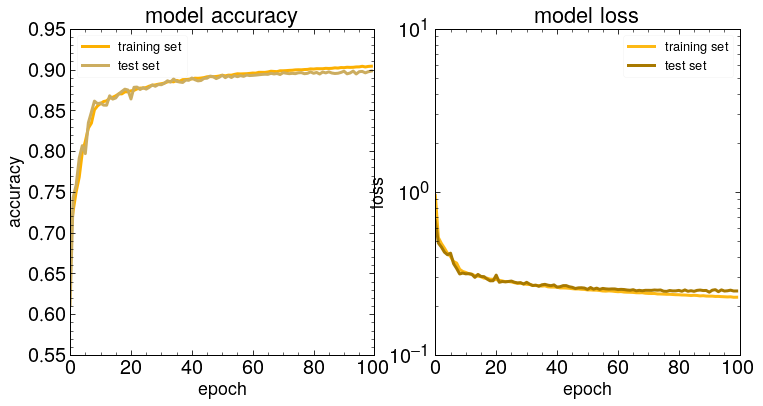

In [103]:
histplots(hist1)

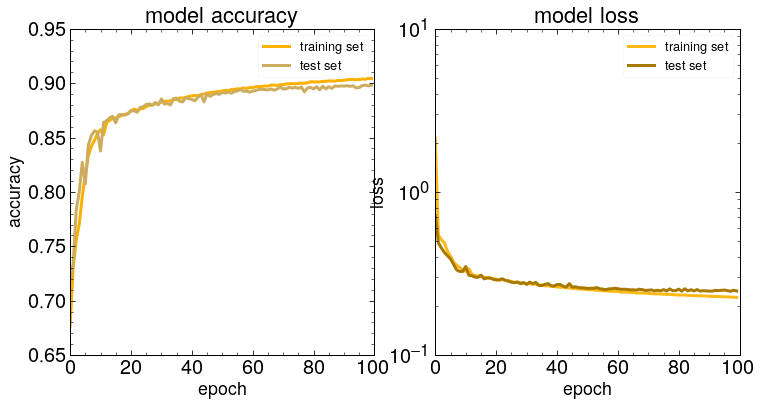

In [104]:
histplots(hist2)

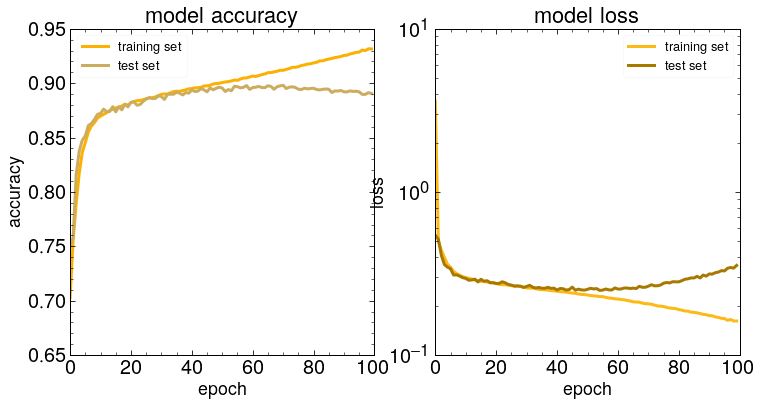

In [40]:
histplots(hist3) #updated with F = 400 -> overfitting, clearly

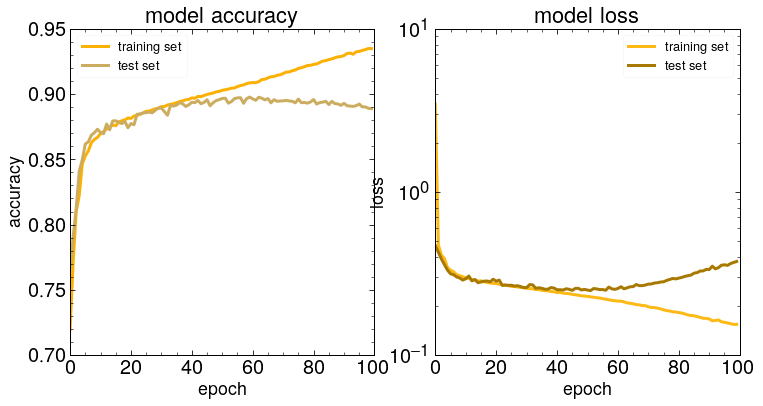

In [41]:
histplots(hist4) #also F=400, overfitting

In [ ]:
histplots(hist5)
histplots(hist6)
histplots(hist7)

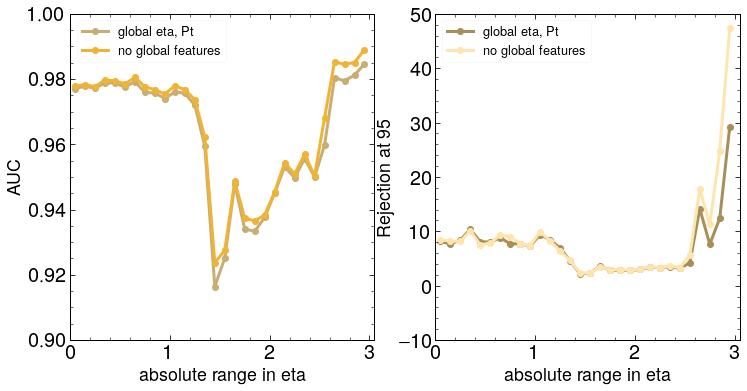

In [71]:
plots1(eta_ranges[:-1], auc_pt_eta[:-1], auc_ng_eta[:-1], reg95_pt_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, Pt')

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)


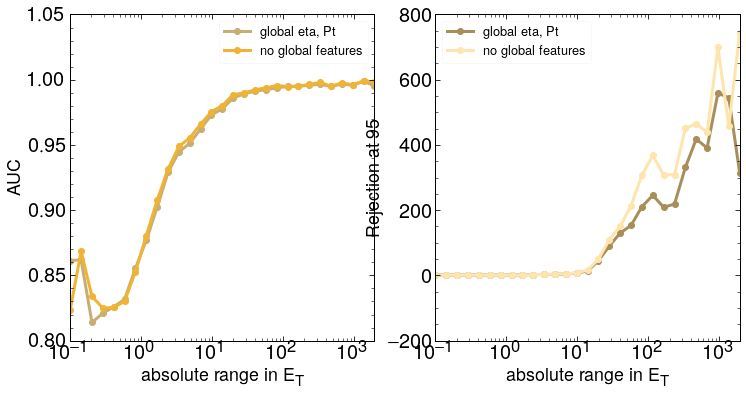

In [72]:
plots1(ET_range, auc_pt_ET[:-1], auc_ng_ET[:-1], reg95_pt_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, Pt', logx=True)

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)


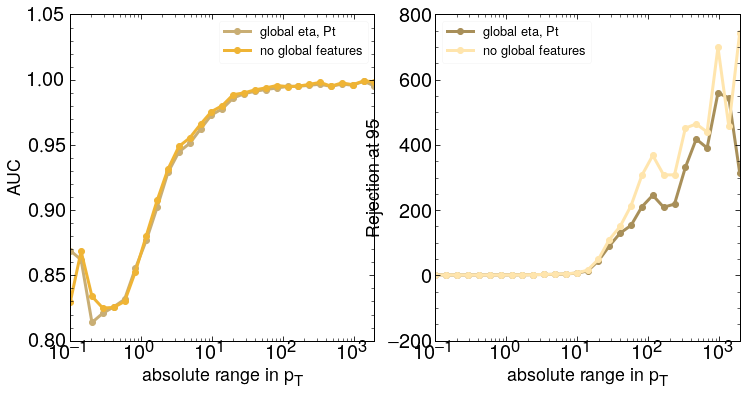

In [75]:
plots1(Pt_range, auc_pt_pt[:-1], auc_ng_pt[:-1], reg95_pt_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, Pt', logx=True)

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)


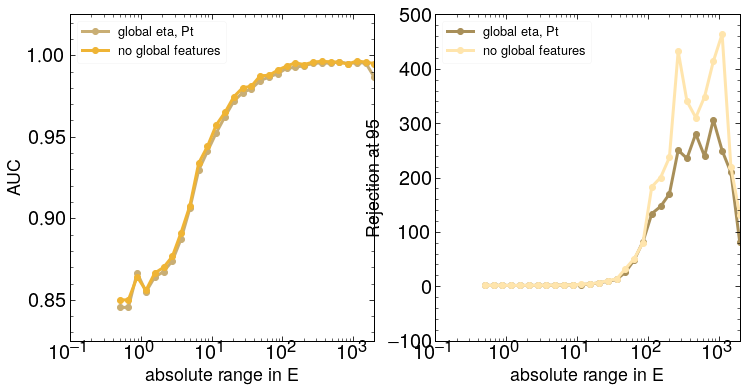

In [76]:
plots1(E_range, auc_pt_E[:-1], auc_ng_E[:-1], reg95_pt_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, Pt', logx=True)

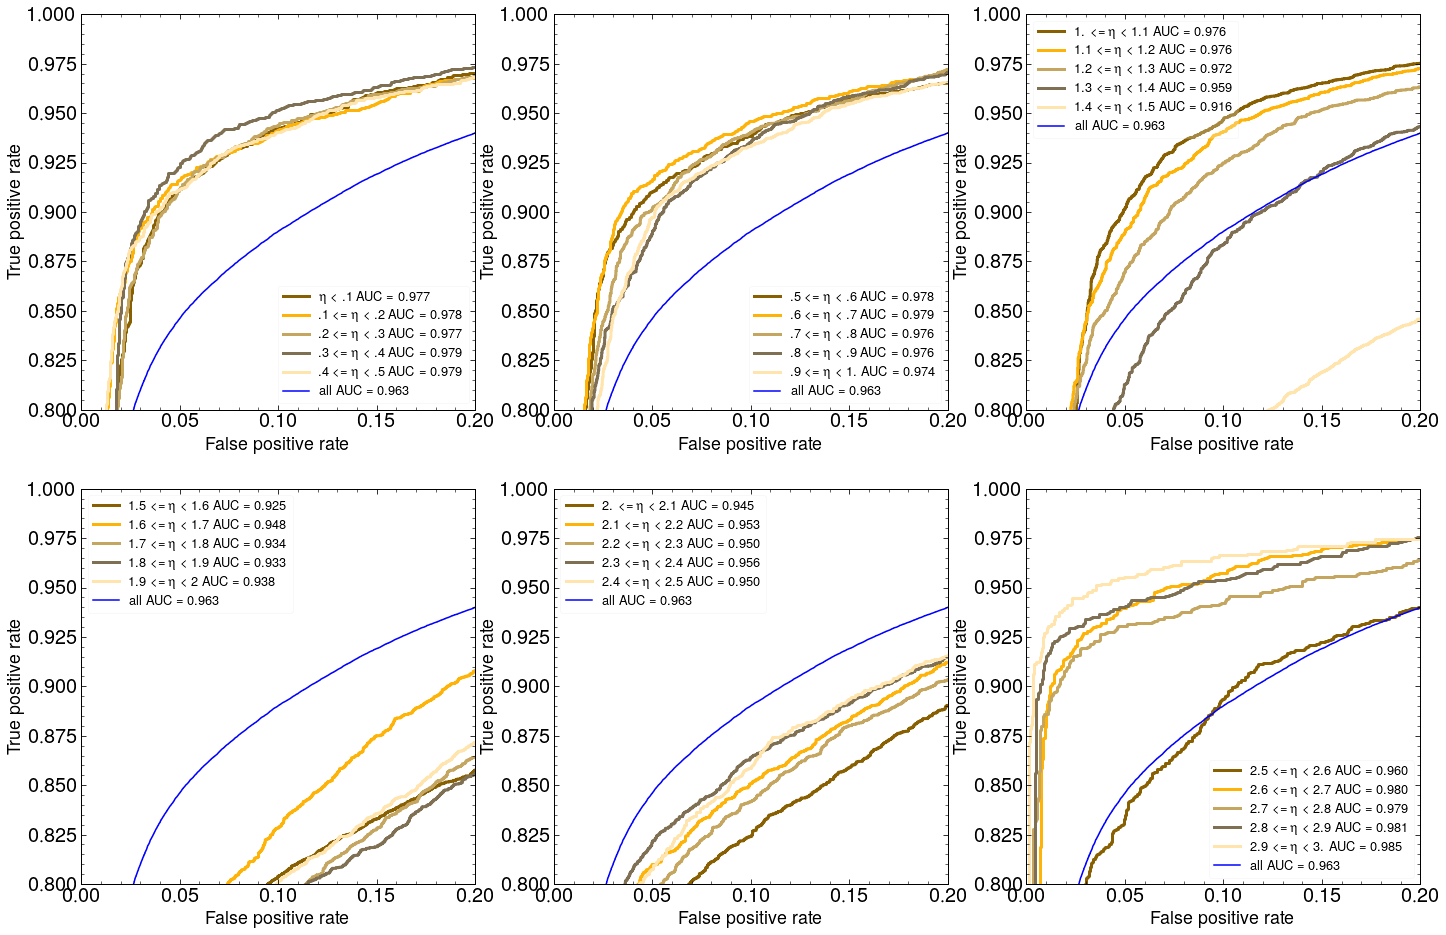

In [61]:
AUCplot(eta_ranges, fps_pt_eta, tps_pt_eta, auc_pt_eta, rangetype='eta')

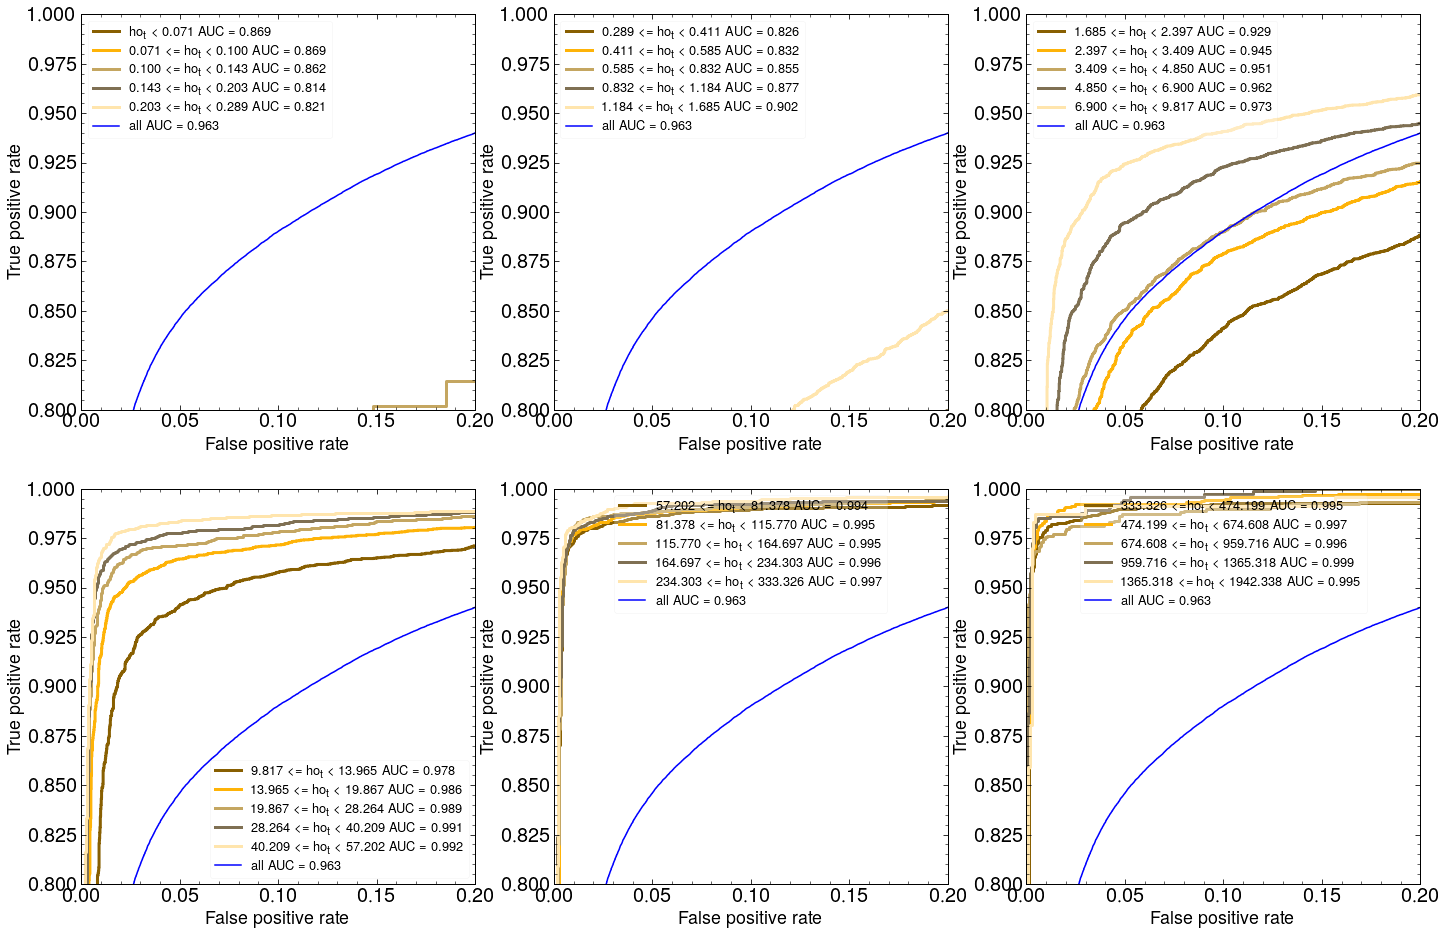

In [63]:
AUCplot(Pt_range, fps_pt_pt, tps_pt_pt, auc_pt_pt, rangetype='Pt')

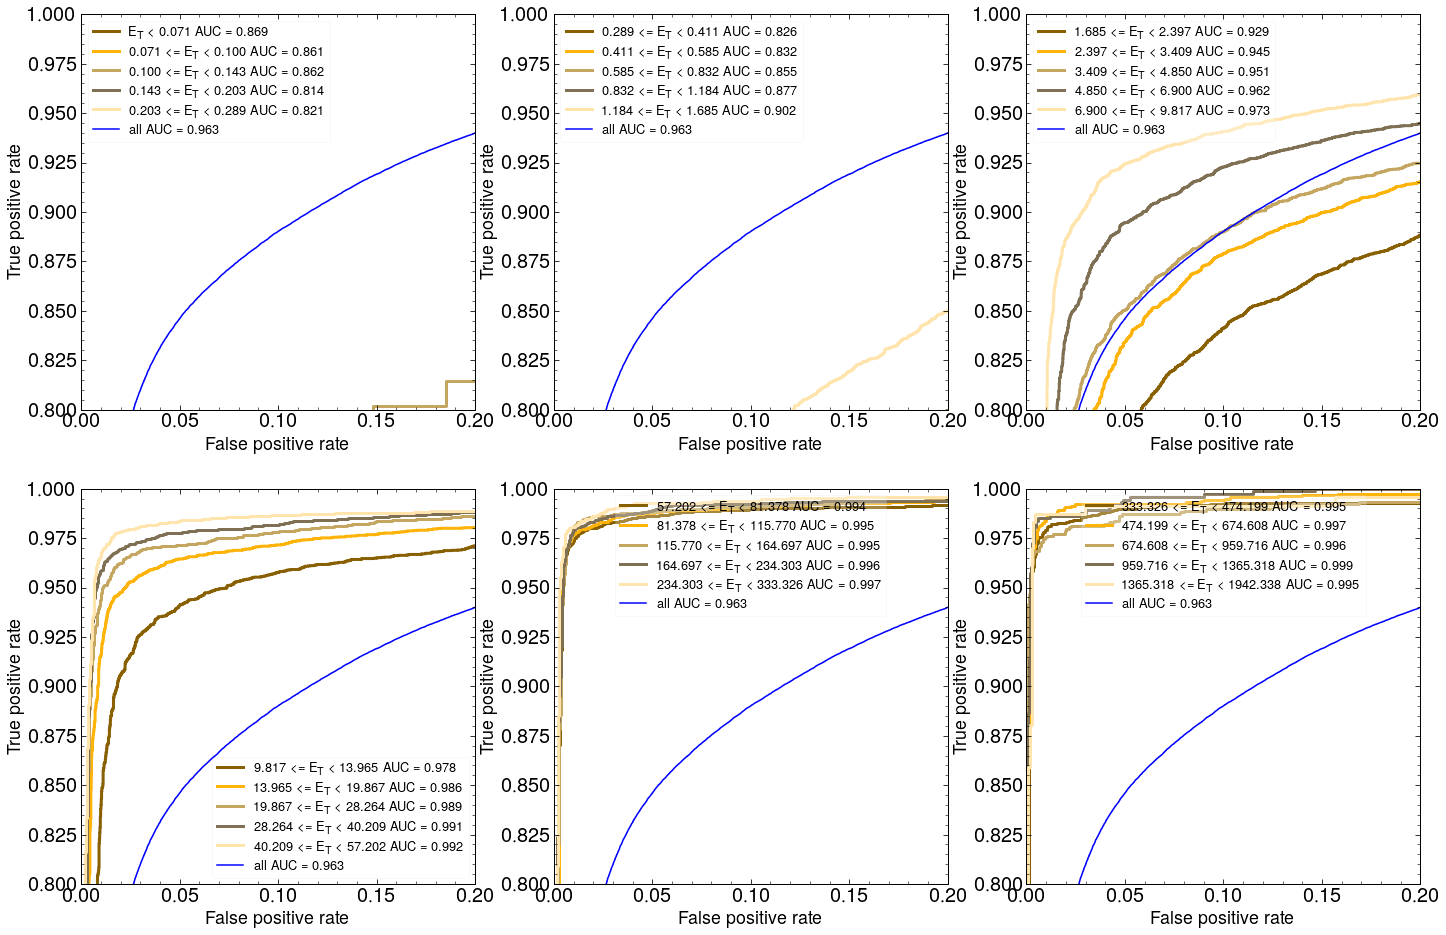

In [64]:
AUCplot(ET_range, fps_pt_ET, tps_pt_ET, auc_pt_ET, rangetype='E_T')

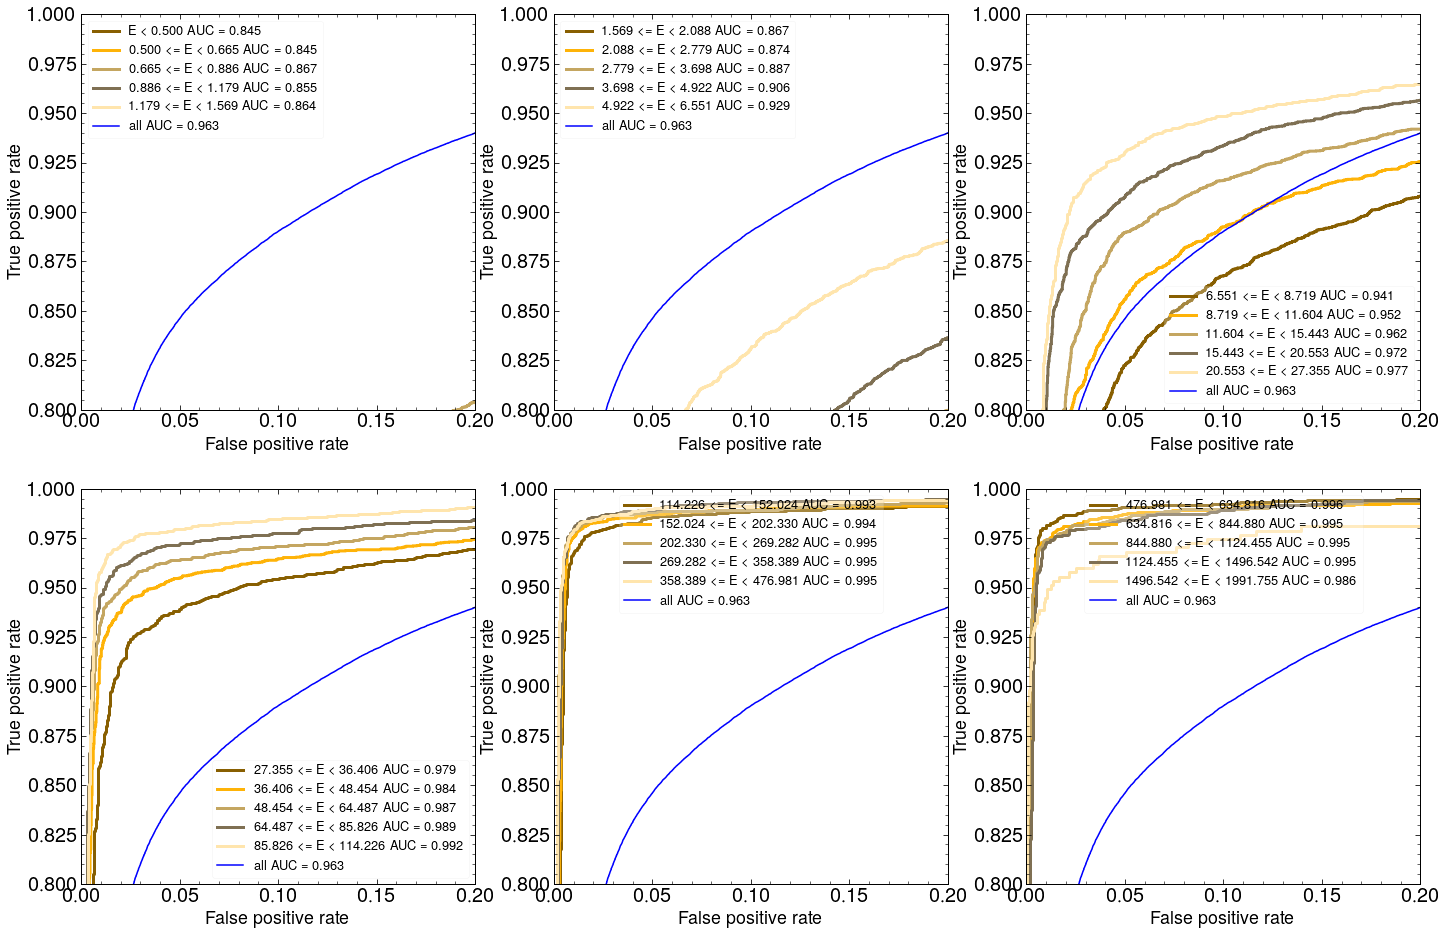

In [65]:
AUCplot(E_range, fps_pt_E, tps_pt_E, auc_pt_E, rangetype='E')

<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-70-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid

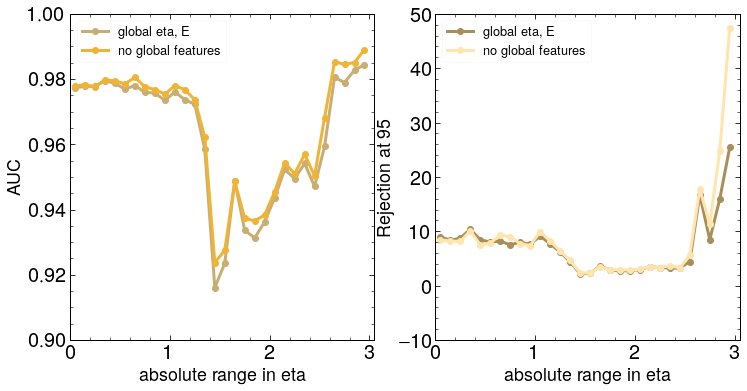

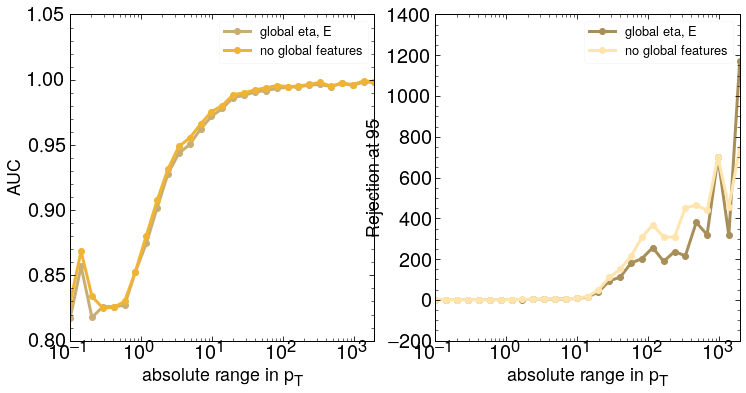

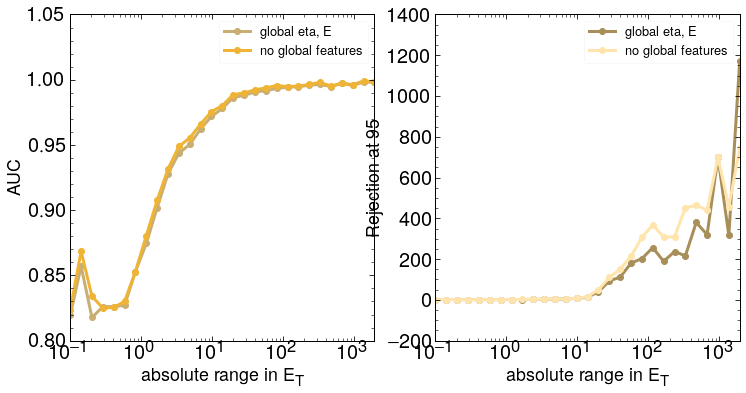

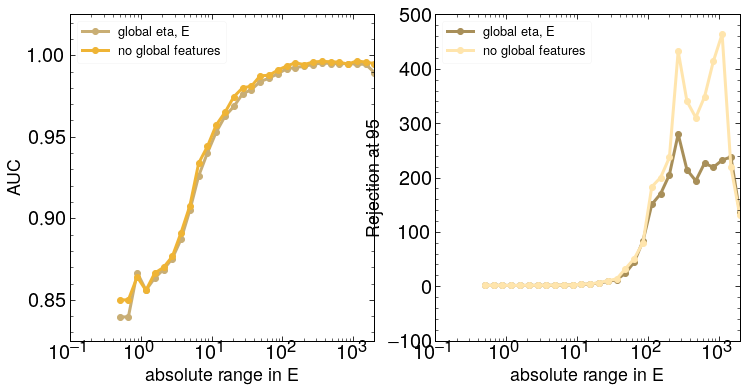

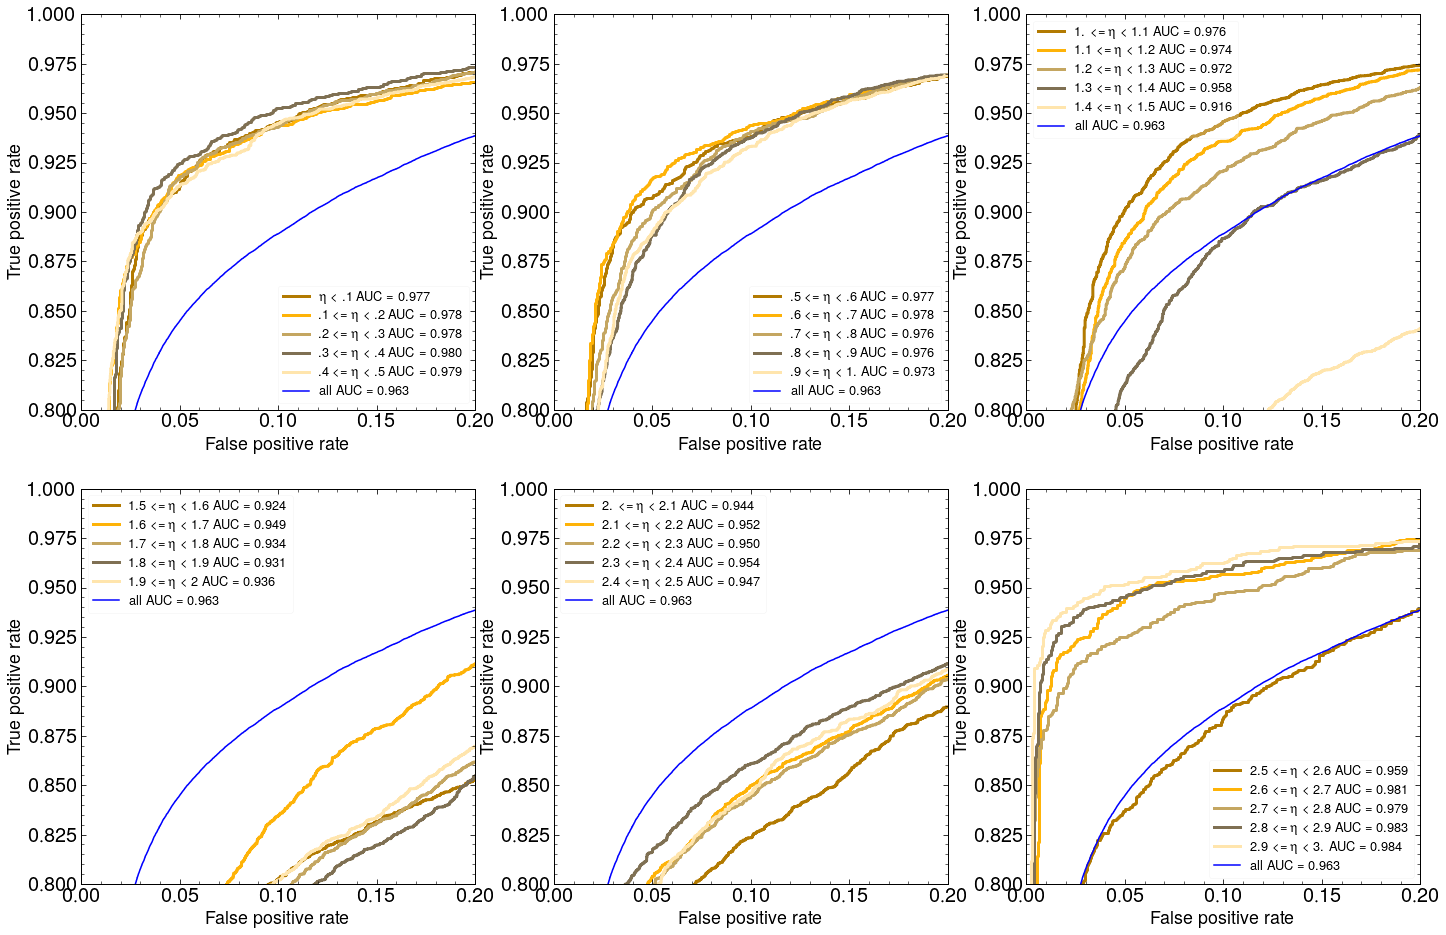

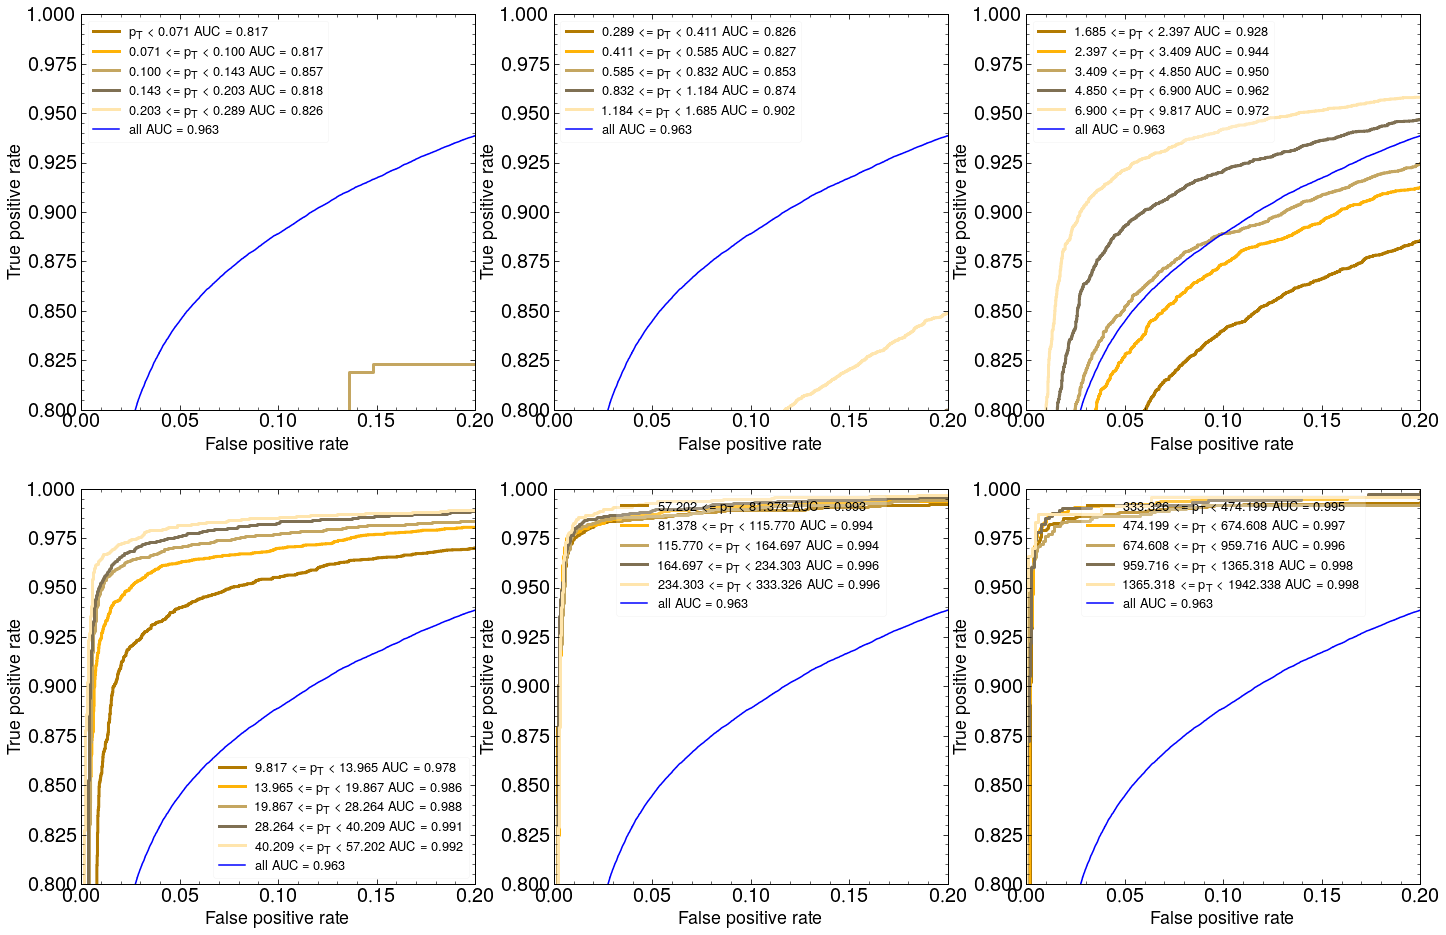

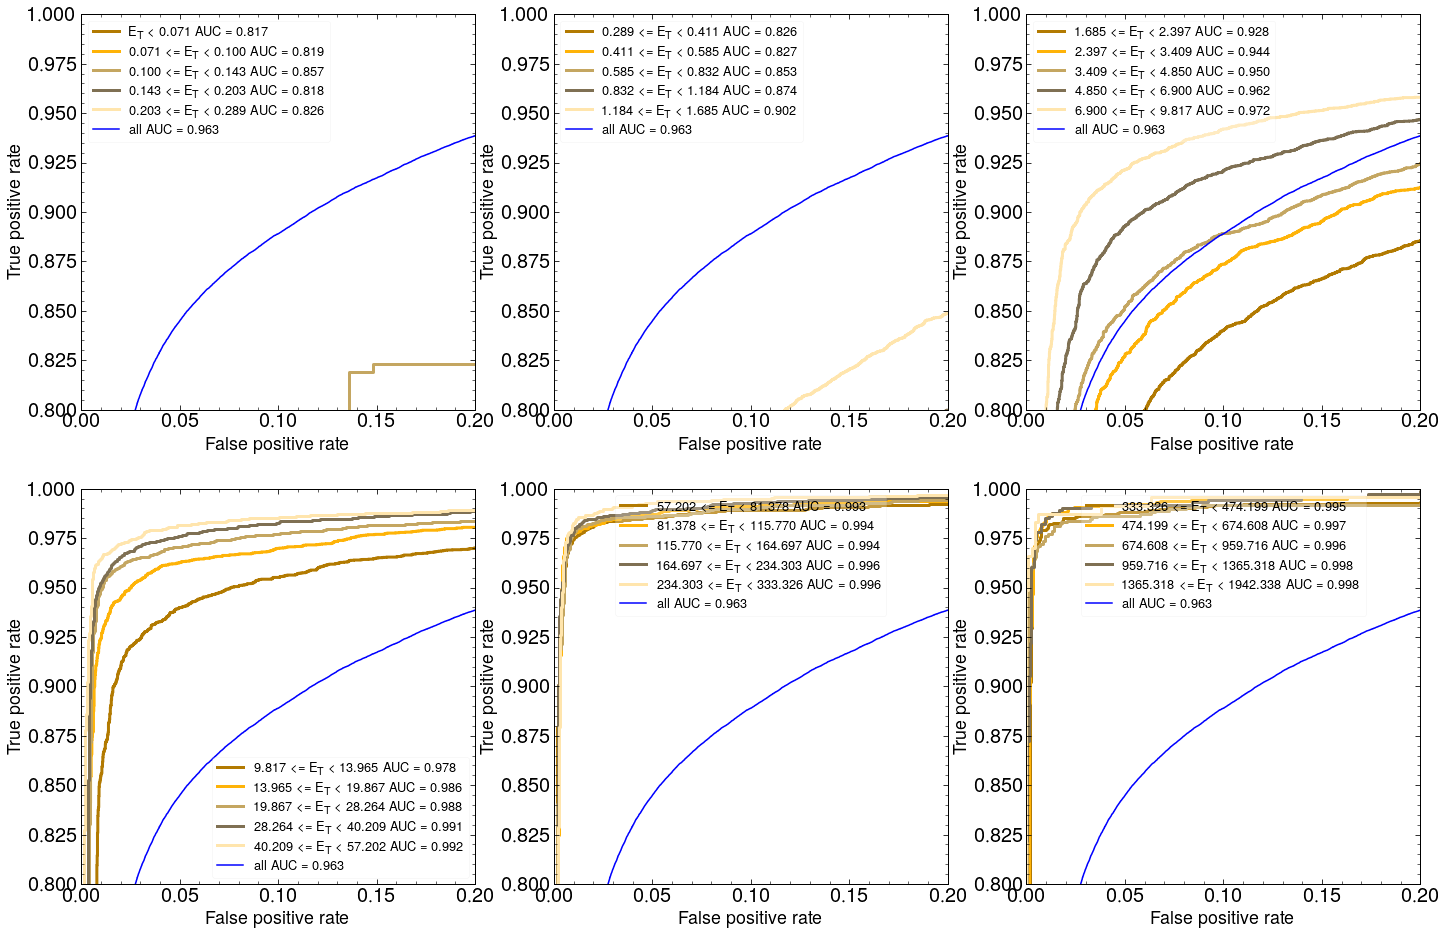

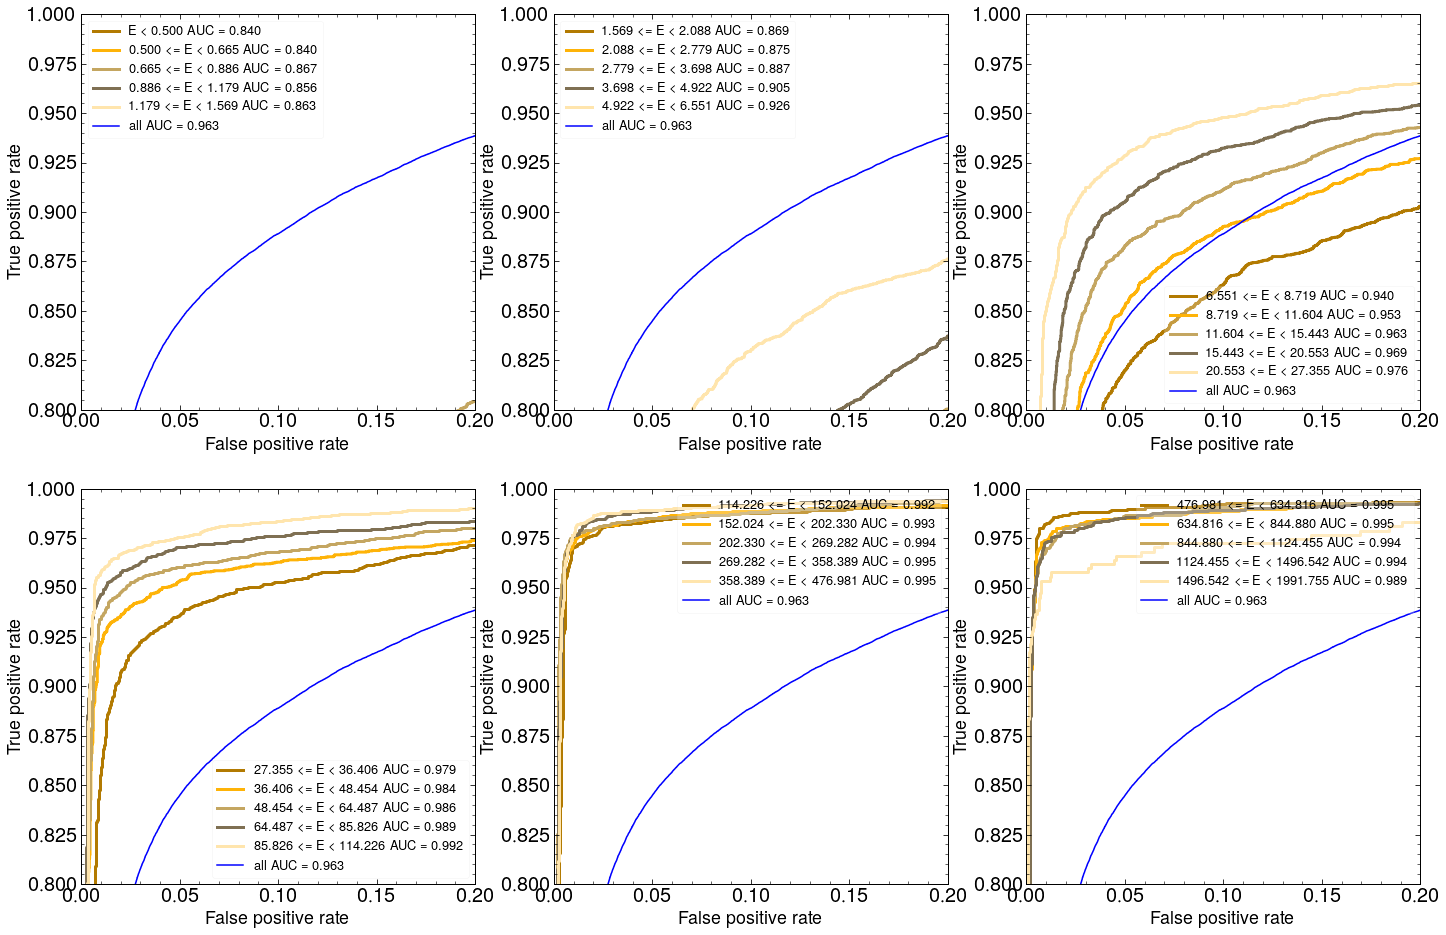

In [79]:
#now for E:
plots1(eta_ranges[:-1], auc_E_eta[:-1], auc_ng_eta[:-1], reg95_E_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, E')
plots1(Pt_range, auc_E_pt[:-1], auc_ng_pt[:-1], reg95_E_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, E', logx=True)
plots1(ET_range, auc_E_ET[:-1], auc_ng_ET[:-1], reg95_E_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, E', logx=True)
plots1(E_range, auc_E_E[:-1], auc_ng_E[:-1], reg95_E_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, E', logx=True)

AUCplot(eta_ranges, fps_E_eta, tps_E_eta, auc_E_eta, rangetype='eta')
AUCplot(Pt_range, fps_E_pt, tps_E_pt, auc_E_pt, rangetype='Pt')
AUCplot(ET_range, fps_E_ET, tps_E_ET, auc_E_ET, rangetype='E_T')
AUCplot(E_range, fps_E_E, tps_E_E, auc_E_E, rangetype='E')

<ipython-input-32-0378a55d3655>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid

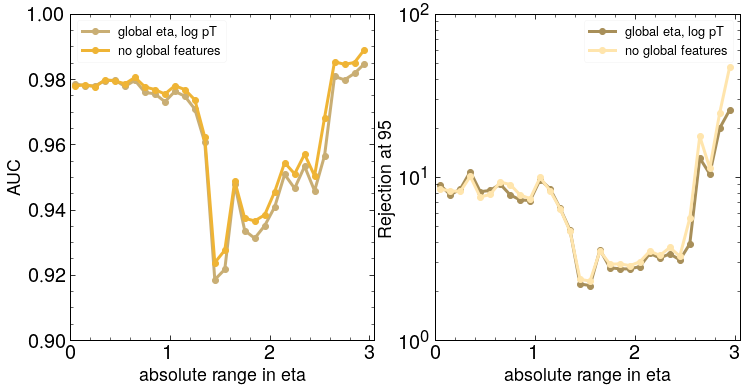

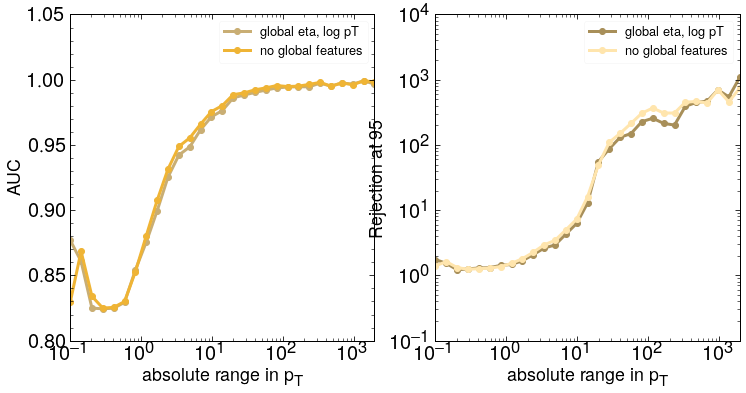

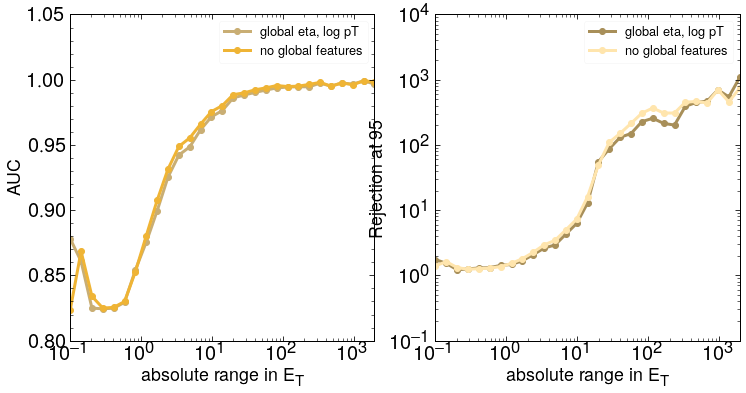

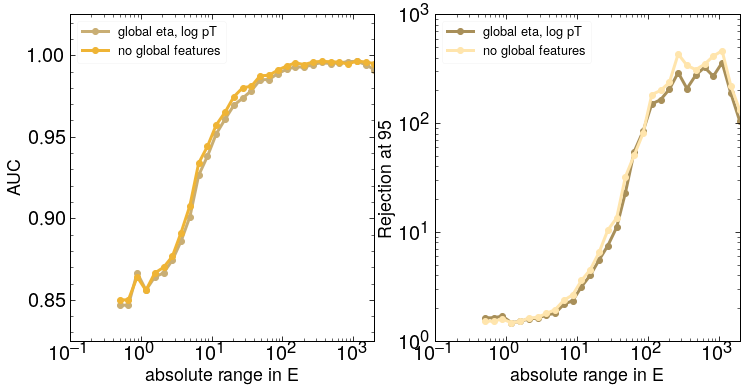

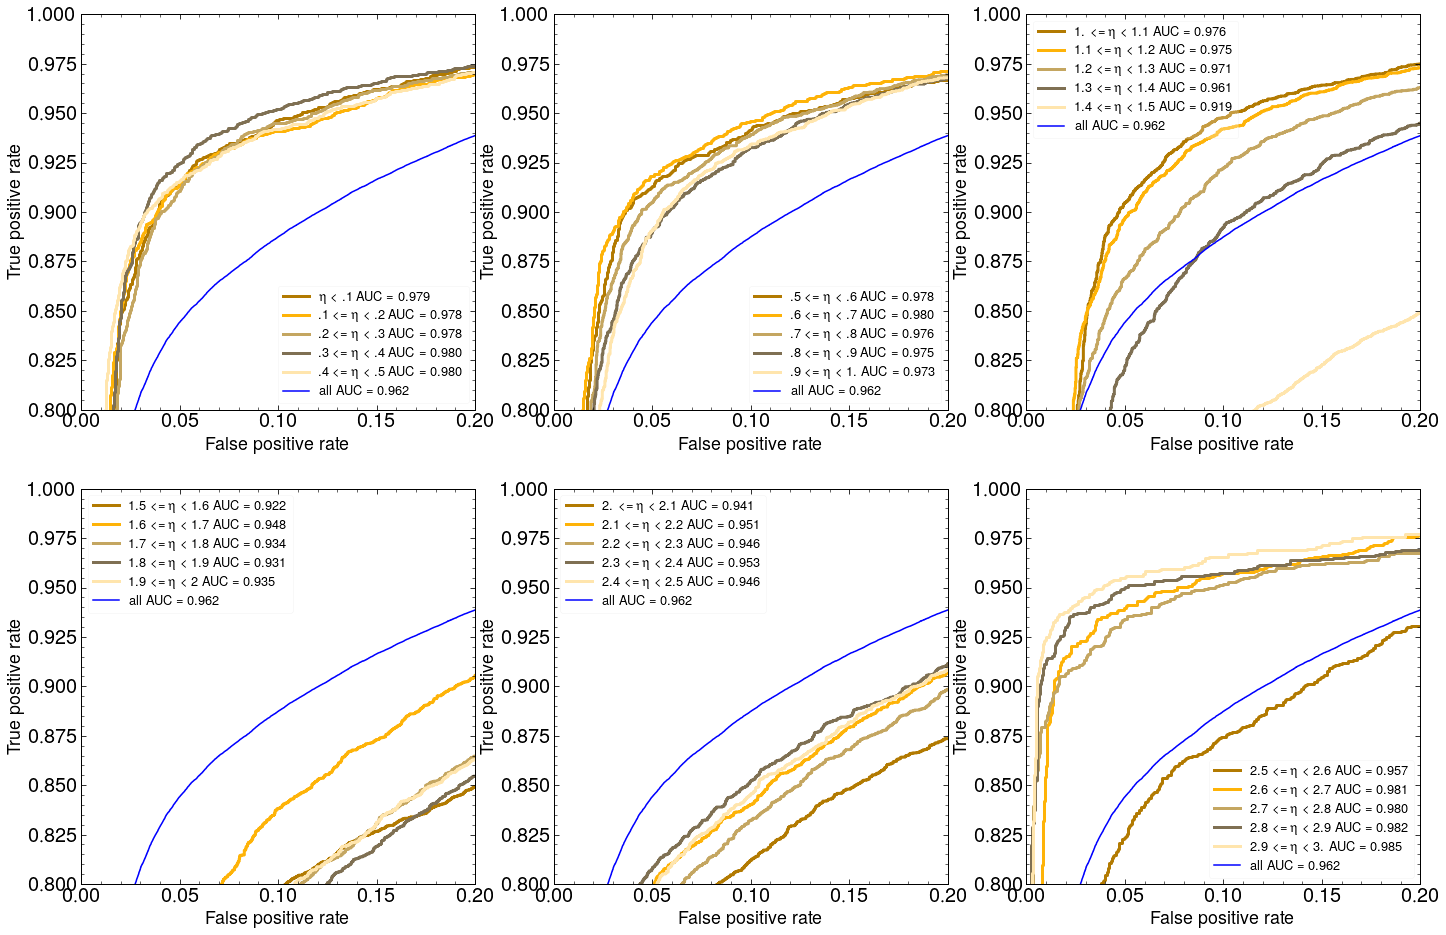

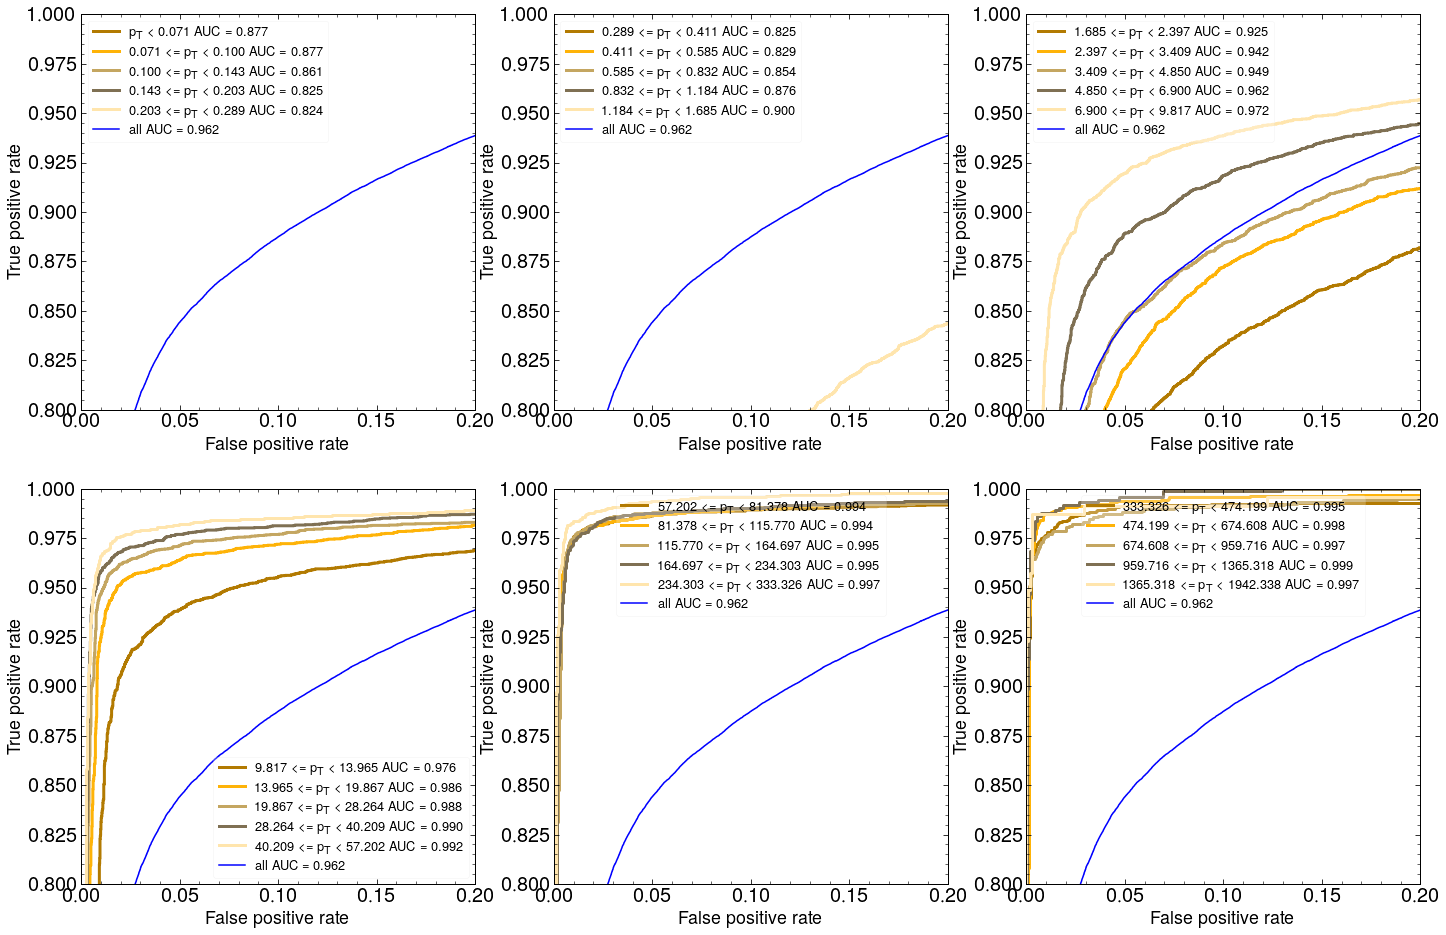

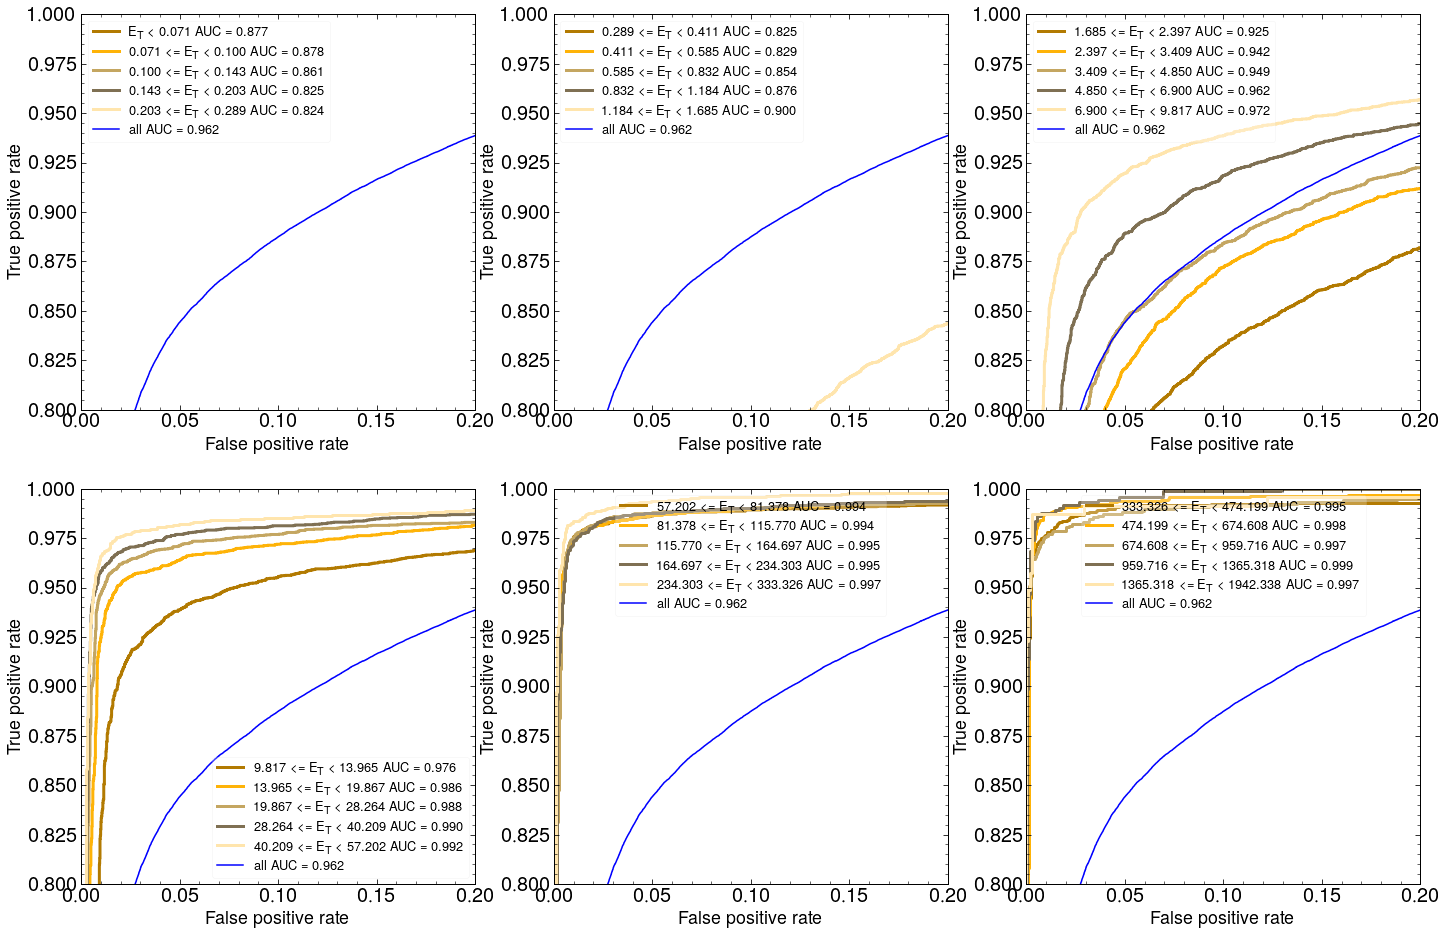

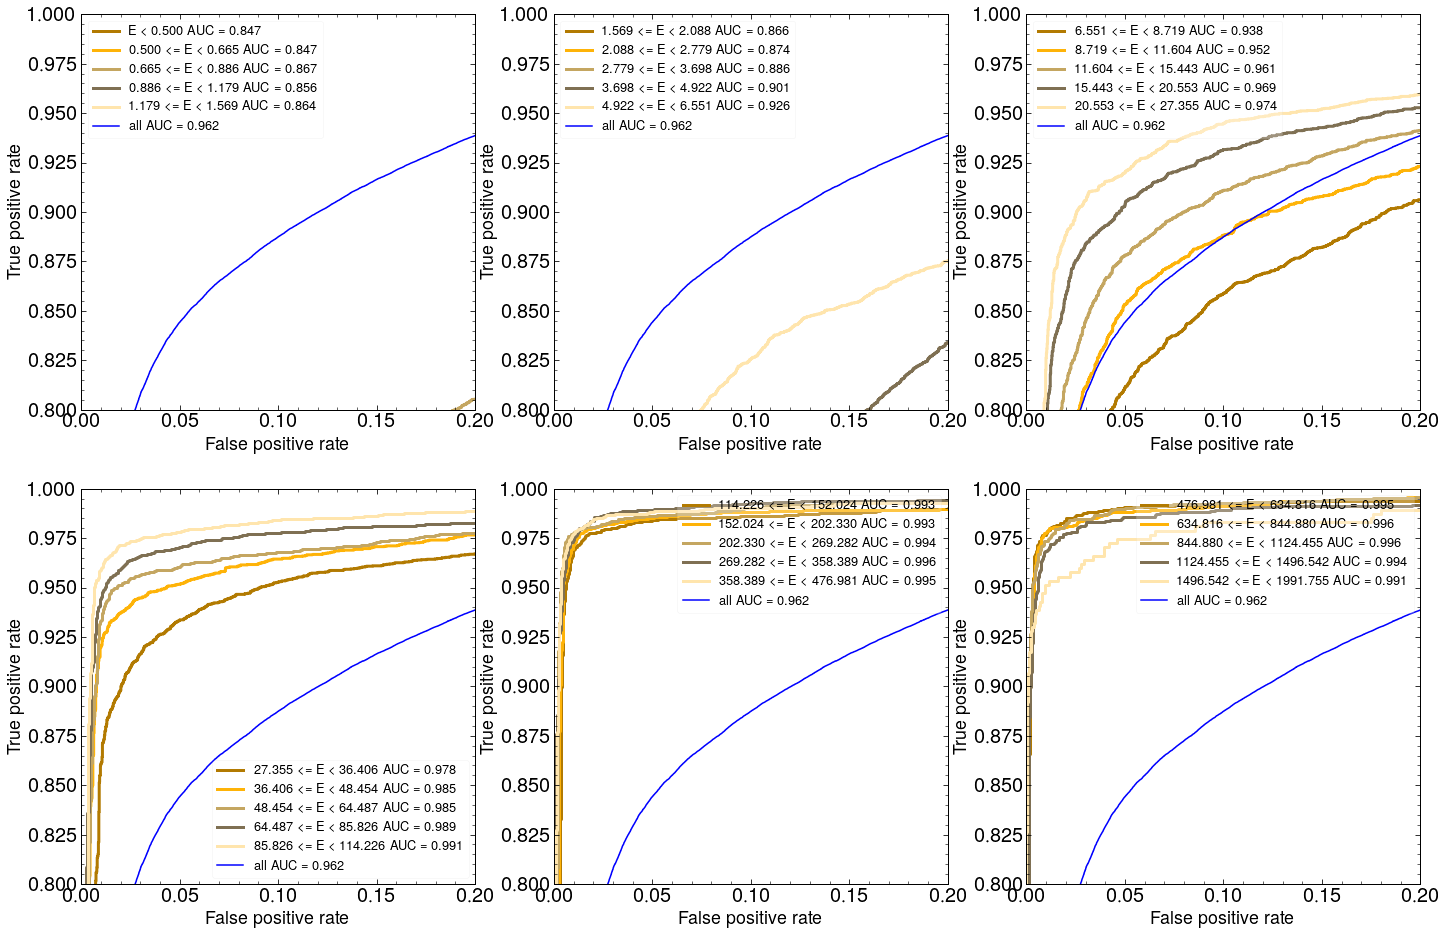

In [42]:
#now for log pT: (updated with F = 400 and log y)
plots1(eta_ranges[:-1], auc_Lpt_eta[:-1], auc_ng_eta[:-1], reg95_Lpt_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, log pT')
plots1(Pt_range, auc_Lpt_pt[:-1], auc_ng_pt[:-1], reg95_Lpt_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, log pT', logx=True)
plots1(ET_range, auc_Lpt_ET[:-1], auc_ng_ET[:-1], reg95_Lpt_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, log pT', logx=True)
plots1(E_range, auc_Lpt_E[:-1], auc_ng_E[:-1], reg95_Lpt_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, log pT', logx=True)

AUCplot(eta_ranges, fps_Lpt_eta, tps_Lpt_eta, auc_Lpt_eta, rangetype='eta')
AUCplot(Pt_range, fps_Lpt_pt, tps_Lpt_pt, auc_Lpt_pt, rangetype='Pt')
AUCplot(ET_range, fps_Lpt_ET, tps_Lpt_ET, auc_Lpt_ET, rangetype='E_T')
AUCplot(E_range, fps_Lpt_E, tps_Lpt_E, auc_Lpt_E, rangetype='E')

<ipython-input-32-0378a55d3655>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-32-0378a55d3655>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid

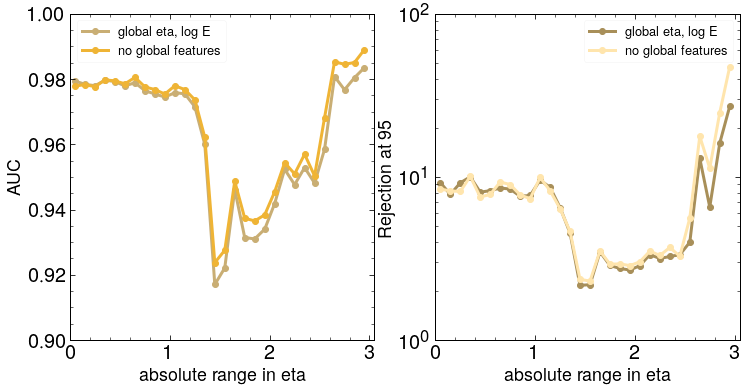

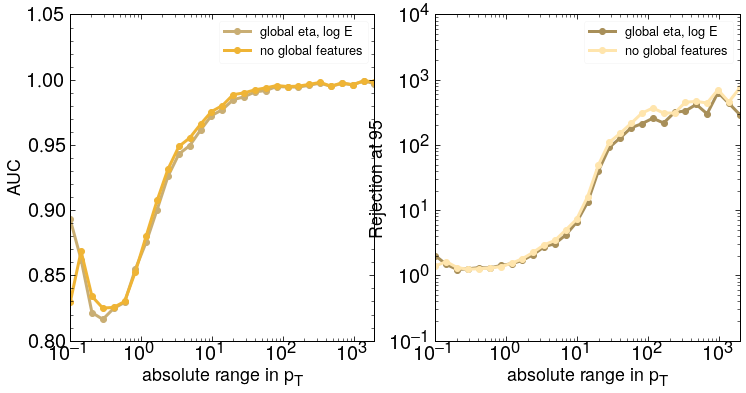

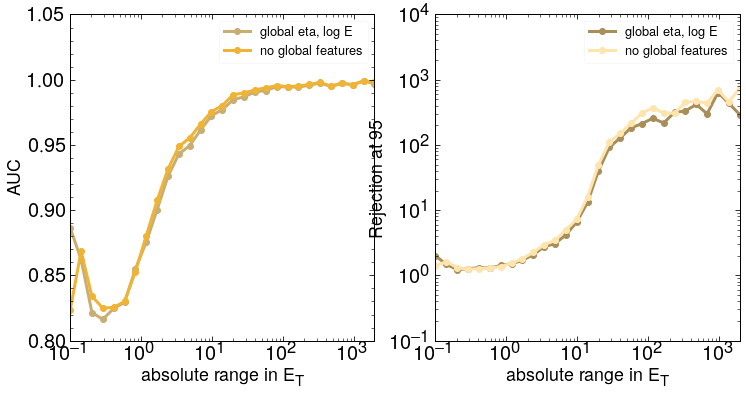

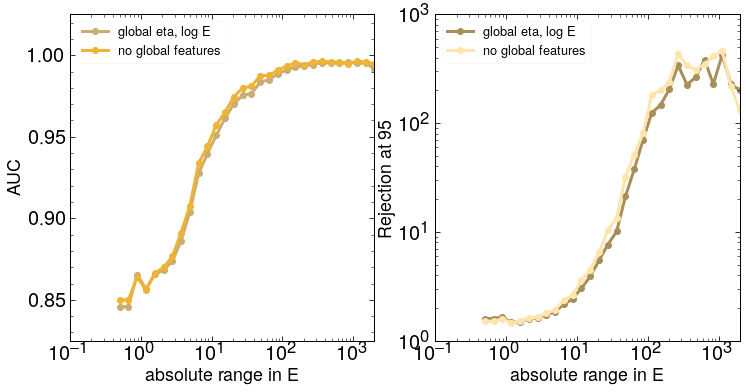

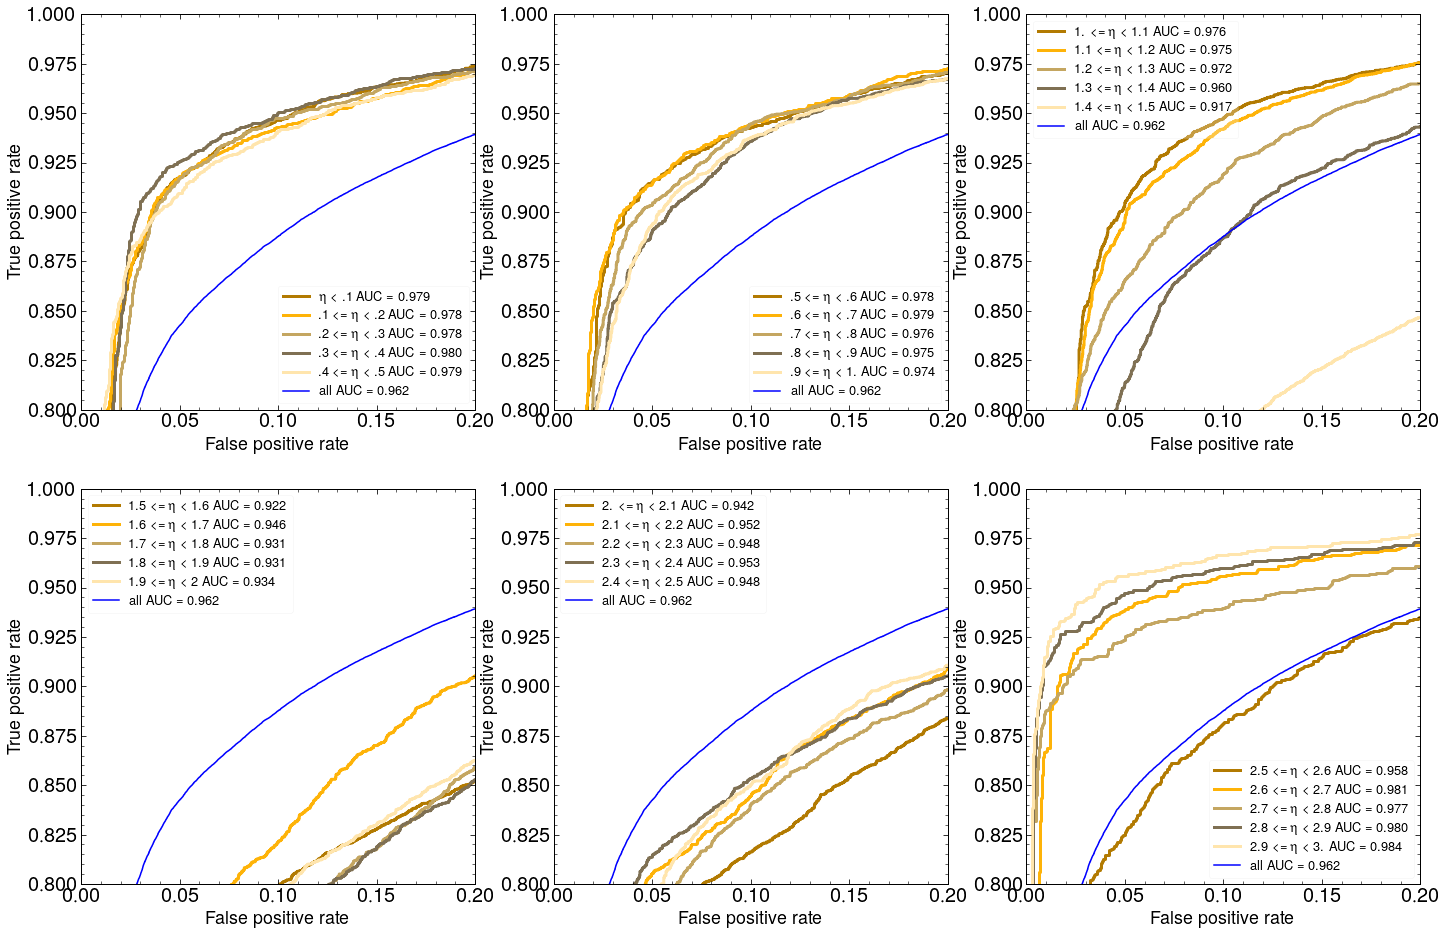

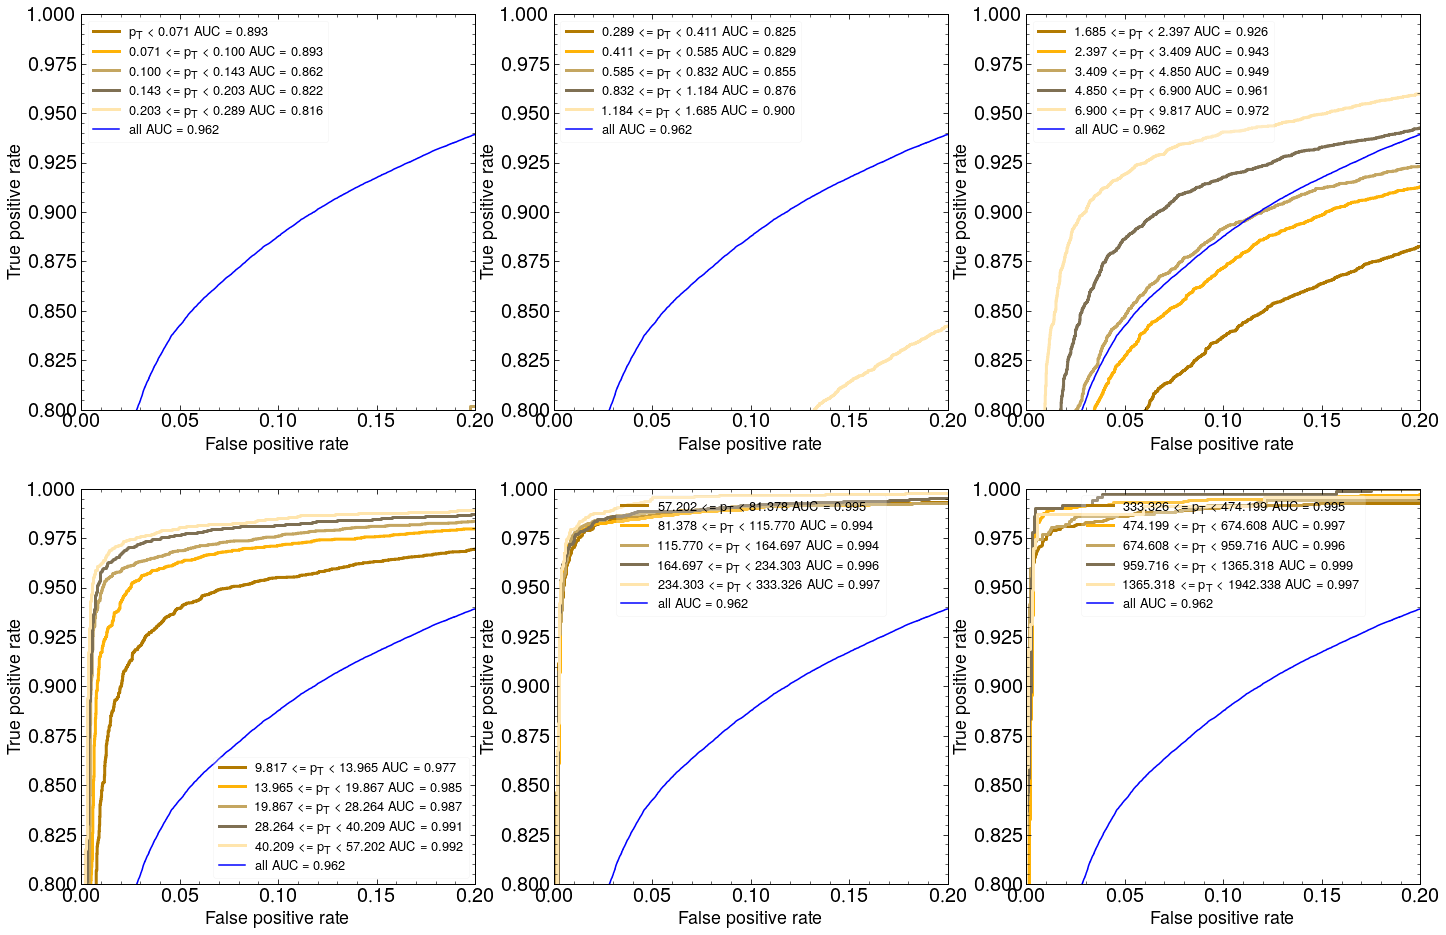

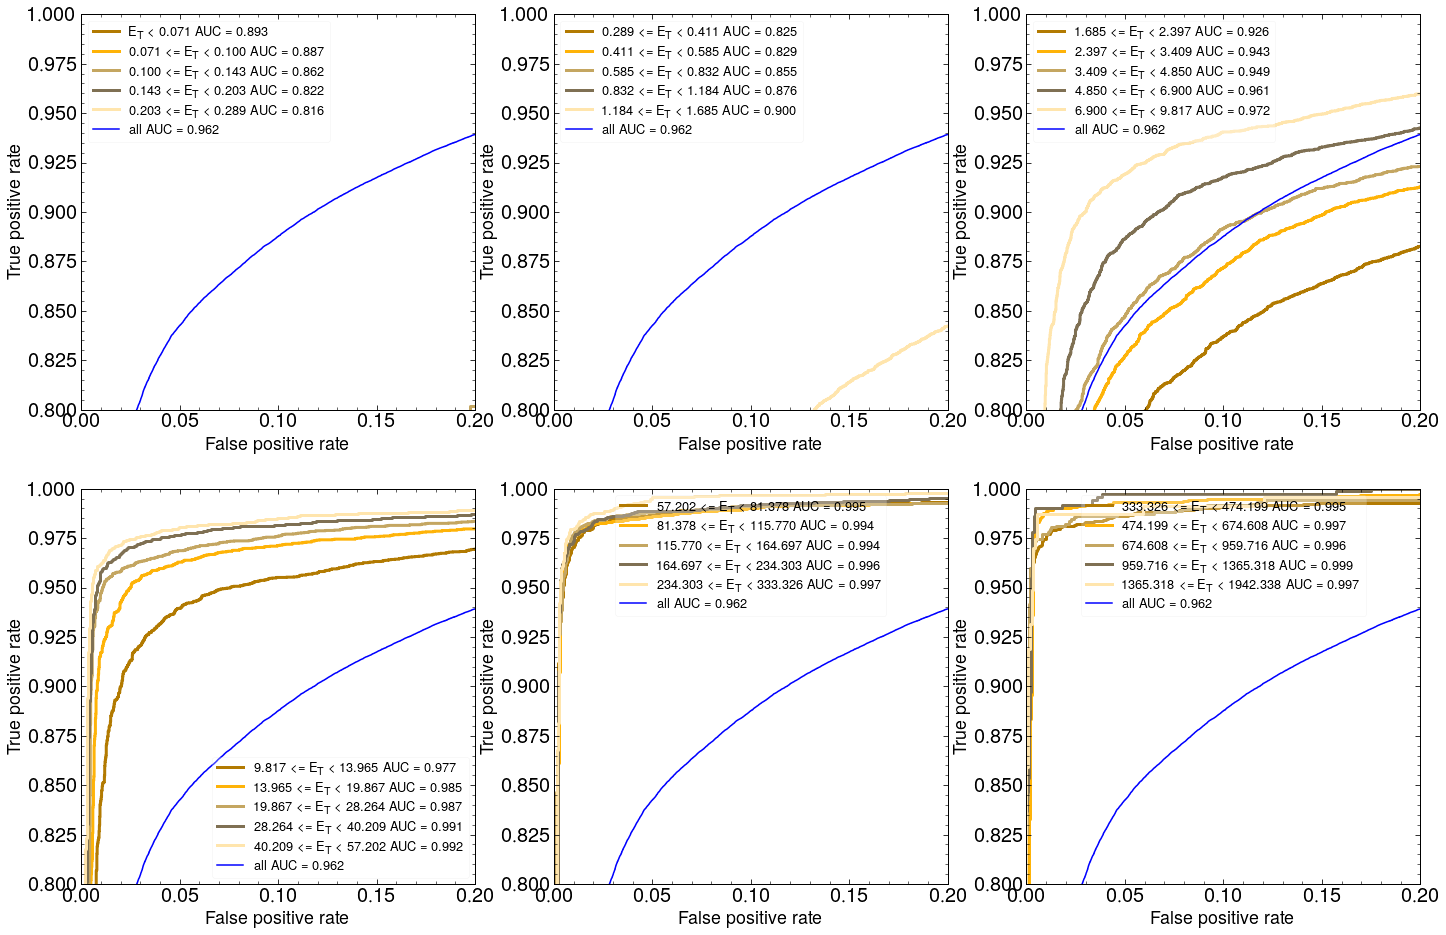

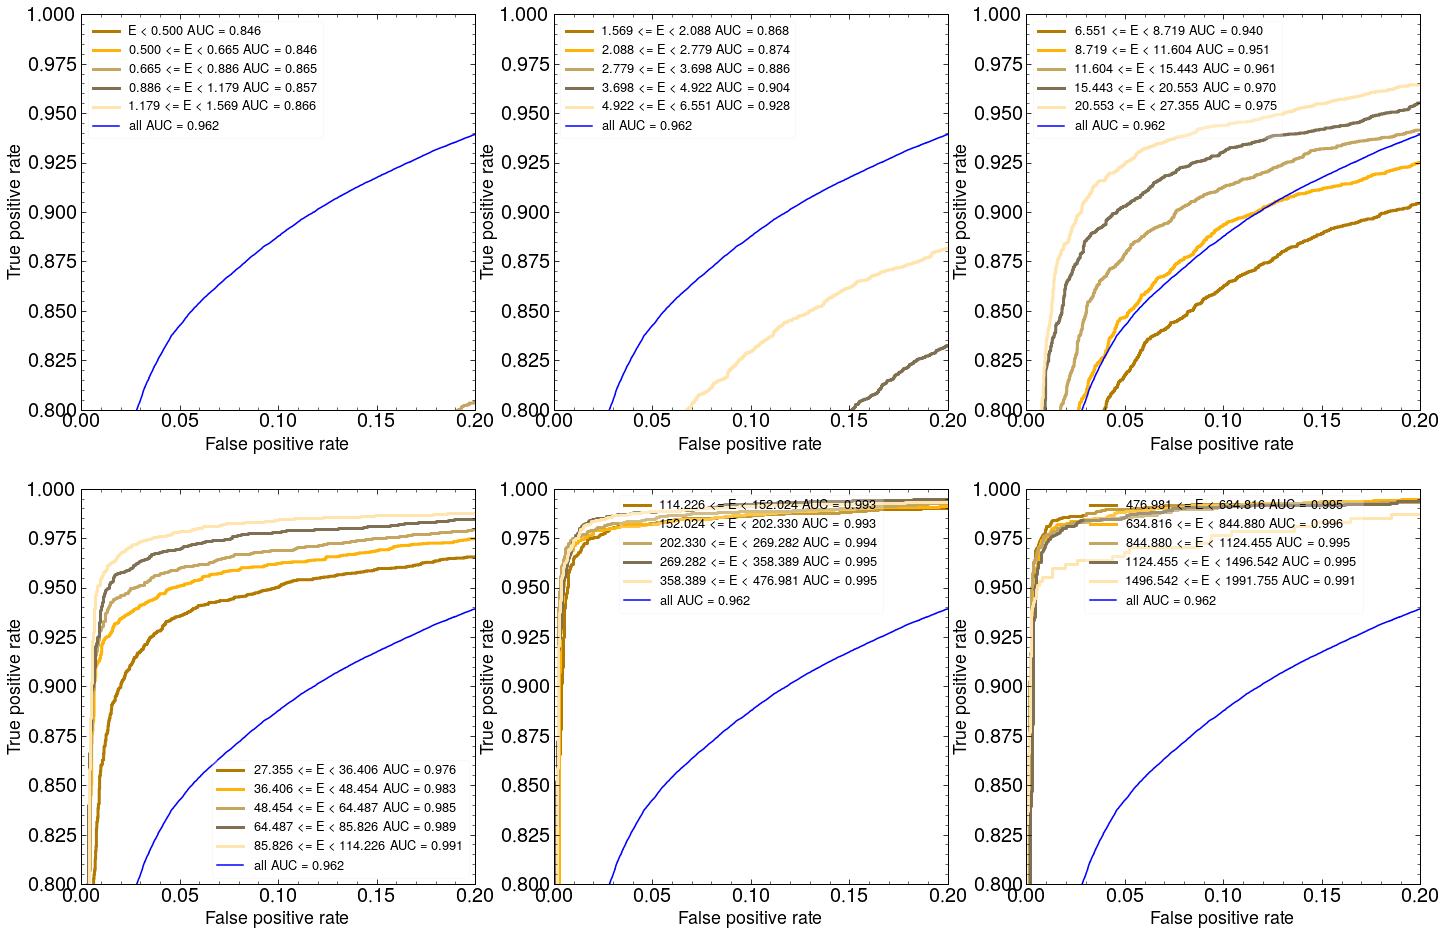

In [43]:
#and log E (updated with F=400 and log y)

plots1(eta_ranges[:-1], auc_LE_eta[:-1], auc_ng_eta[:-1], reg95_LE_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, log E')
plots1(Pt_range, auc_LE_pt[:-1], auc_ng_pt[:-1], reg95_LE_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, log E', logx=True)
plots1(ET_range, auc_LE_ET[:-1], auc_ng_ET[:-1], reg95_LE_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, log E', logx=True)
plots1(E_range, auc_LE_E[:-1], auc_ng_E[:-1], reg95_LE_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, log E', logx=True)

AUCplot(eta_ranges, fps_LE_eta, tps_LE_eta, auc_LE_eta, rangetype='eta')
AUCplot(Pt_range, fps_LE_pt, tps_LE_pt, auc_LE_pt, rangetype='Pt')
AUCplot(ET_range, fps_LE_ET, tps_LE_ET, auc_LE_ET, rangetype='E_T')
AUCplot(E_range, fps_LE_E, tps_LE_E, auc_LE_E, rangetype='E')

<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid

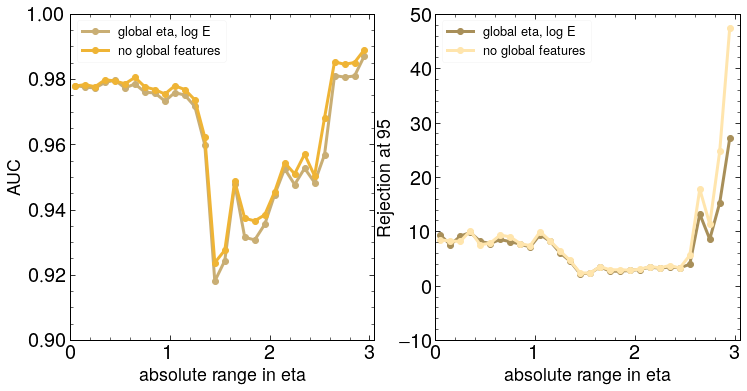

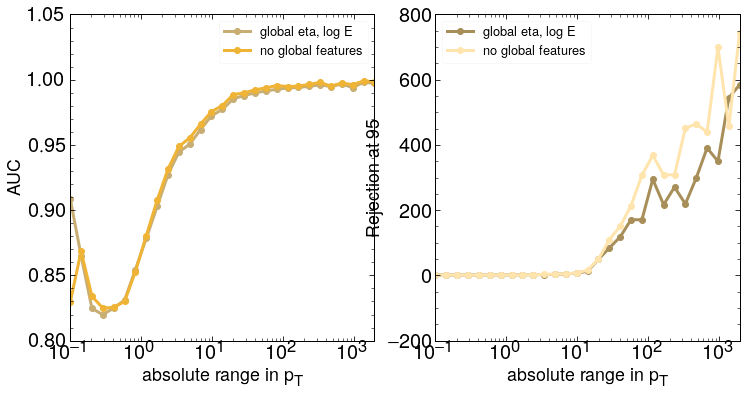

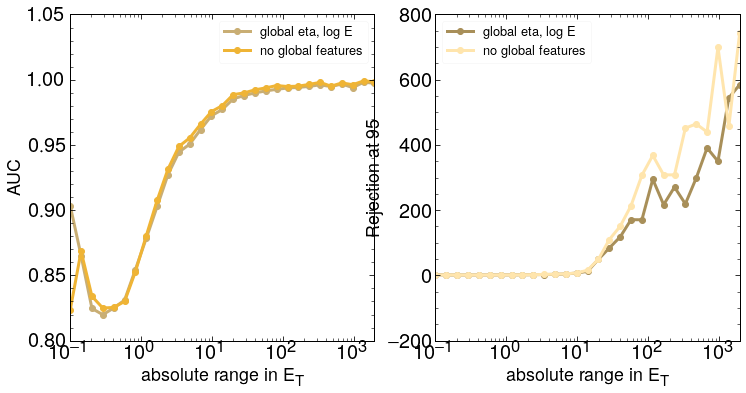

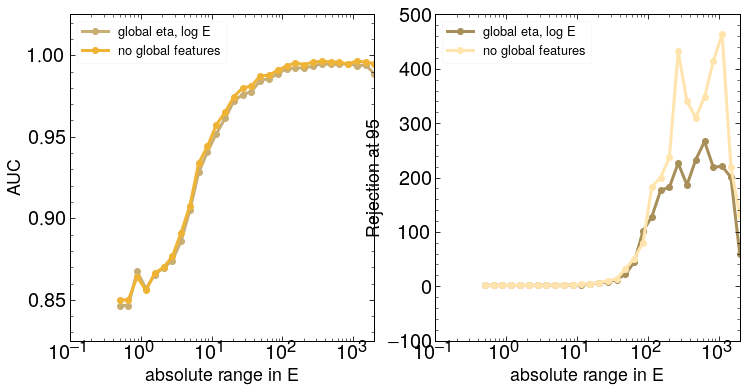

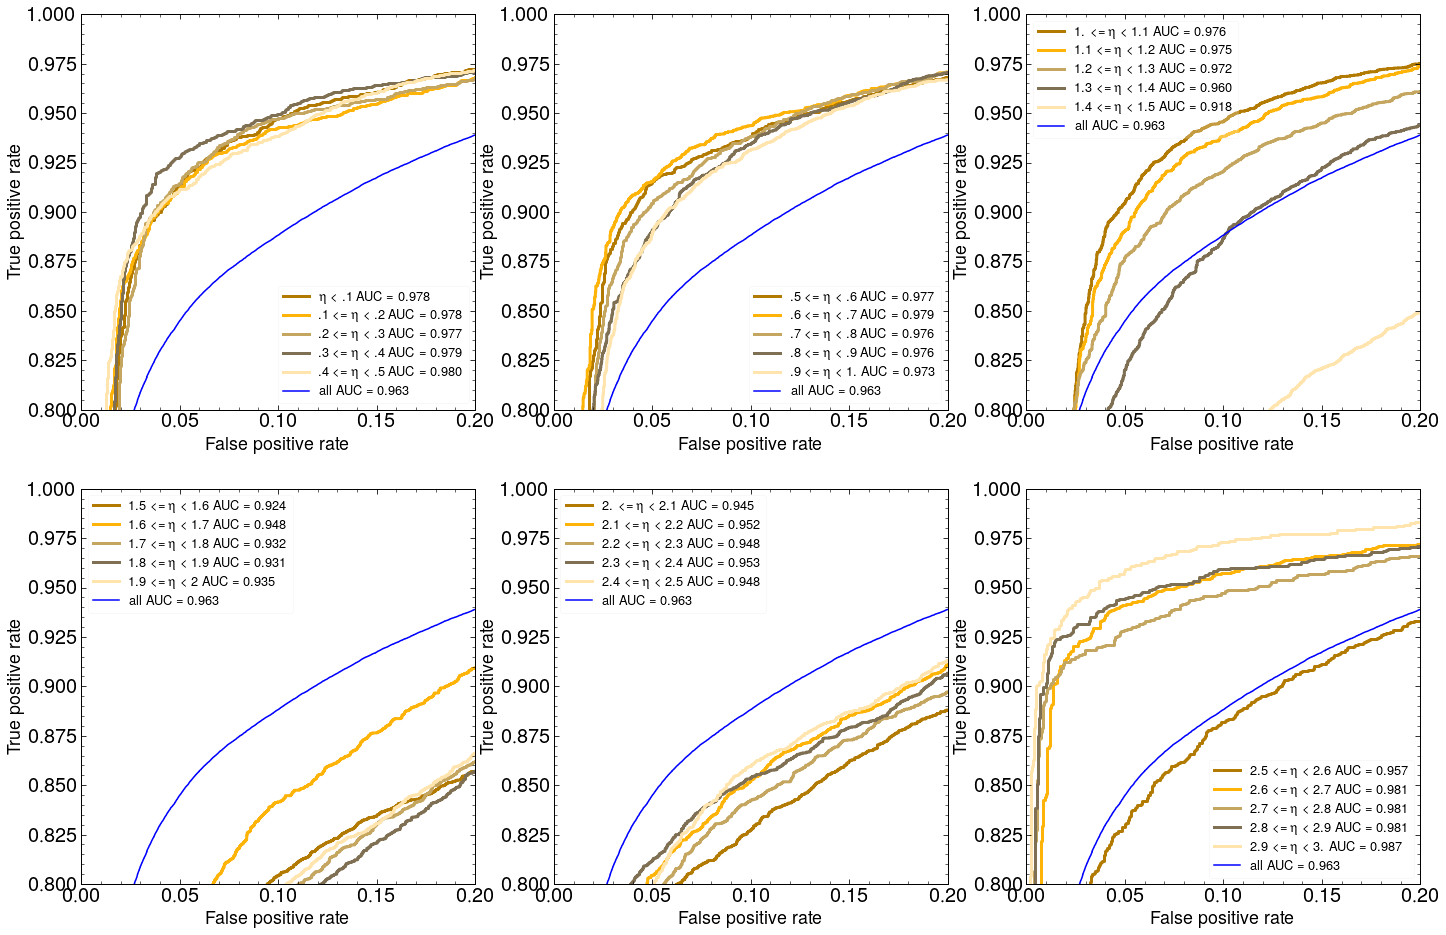

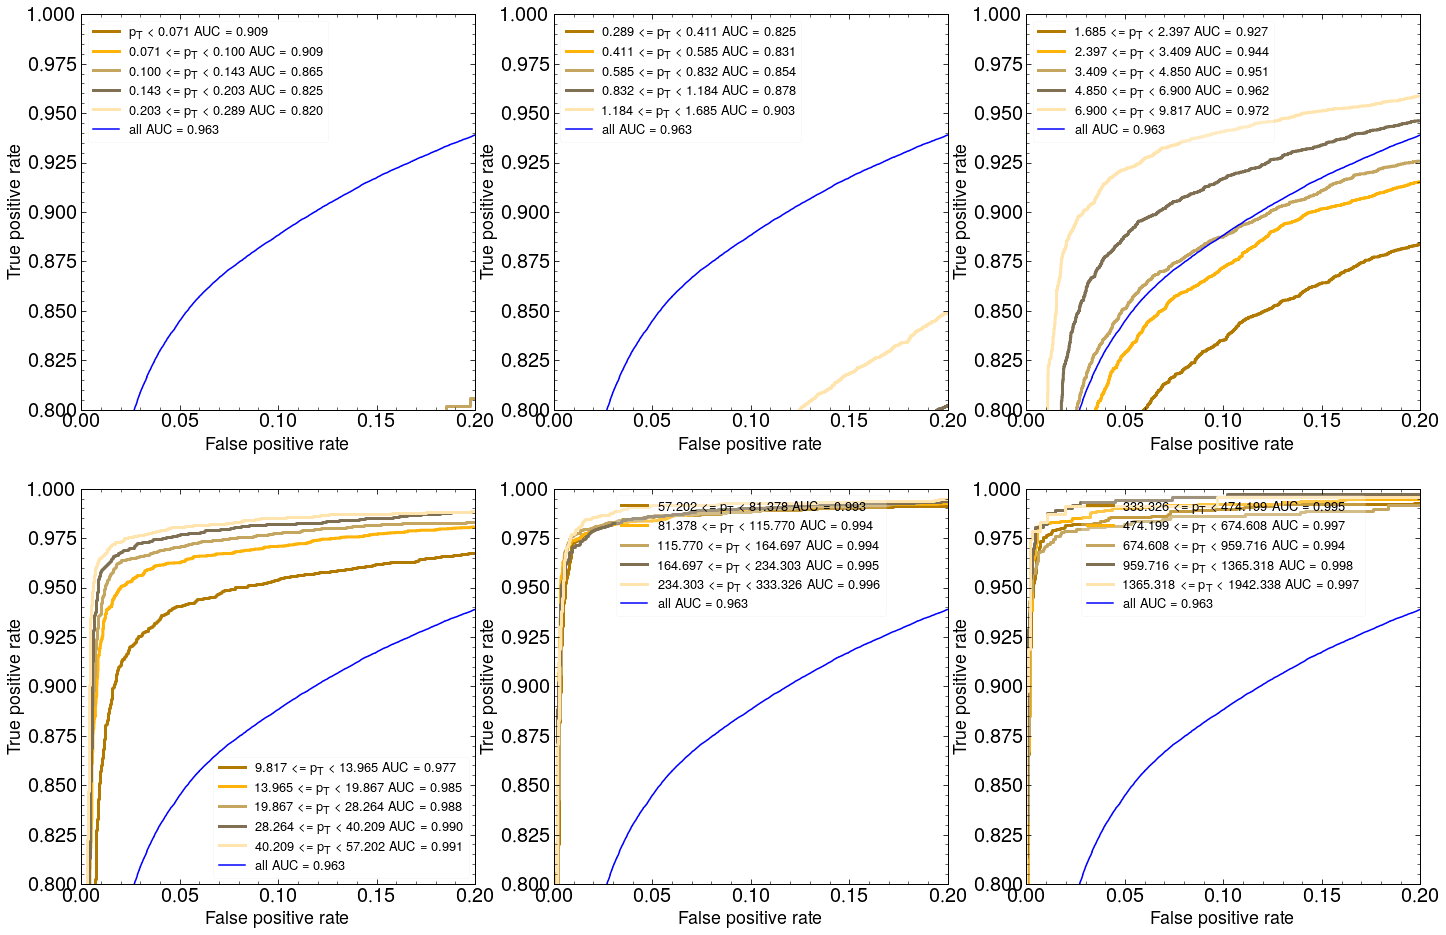

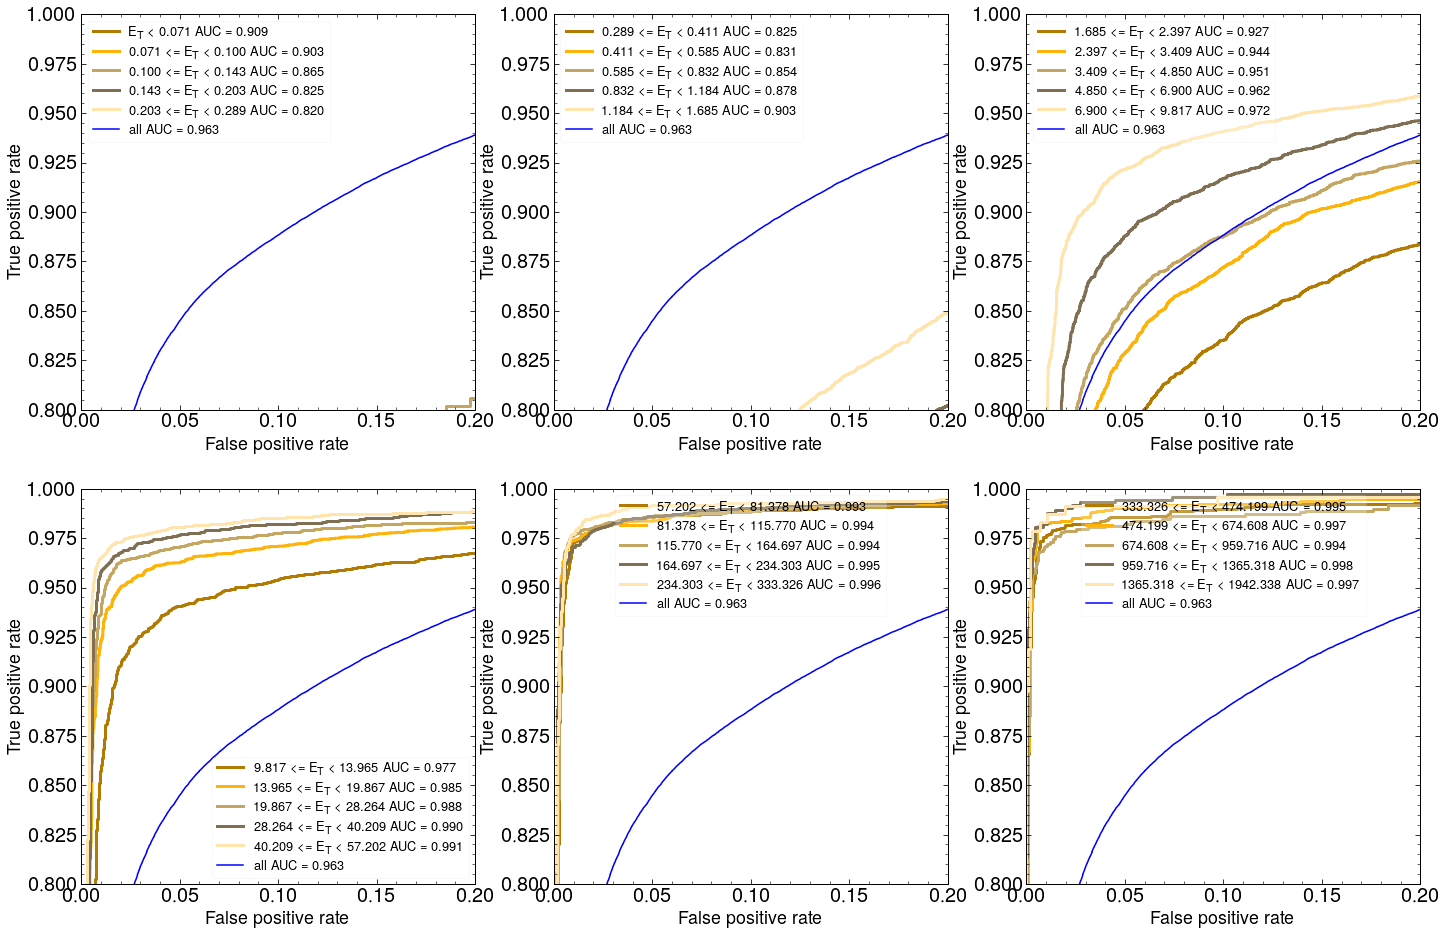

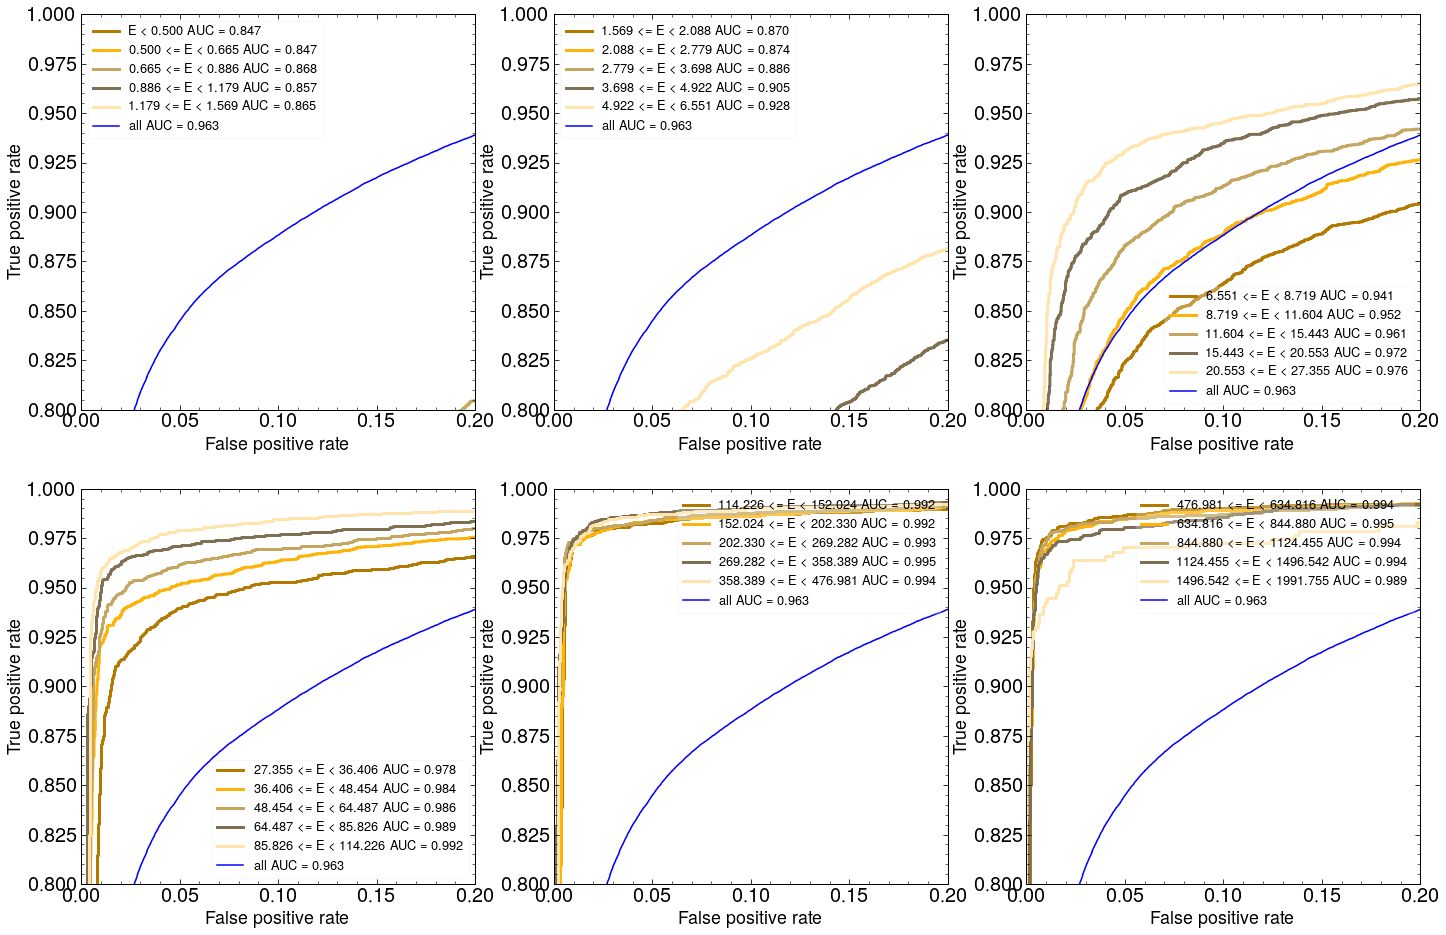

In [29]:
#with F = 200
plots1(eta_ranges[:-1], auc_LEBF_eta[:-1], auc_ng_eta[:-1], reg95_LEBF_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, log E')
plots1(Pt_range, auc_LEBF_pt[:-1], auc_ng_pt[:-1], reg95_LEBF_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, log E', logx=True)
plots1(ET_range, auc_LEBF_ET[:-1], auc_ng_ET[:-1], reg95_LEBF_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, log E', logx=True)
plots1(E_range, auc_LEBF_E[:-1], auc_ng_E[:-1], reg95_LEBF_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, log E', logx=True)

AUCplot(eta_ranges, fps_LEBF_eta, tps_LEBF_eta, auc_LEBF_eta, rangetype='eta')
AUCplot(Pt_range, fps_LEBF_pt, tps_LEBF_pt, auc_LEBF_pt, rangetype='Pt')
AUCplot(ET_range, fps_LEBF_ET, tps_LEBF_ET, auc_LEBF_ET, rangetype='E_T')
AUCplot(E_range, fps_LEBF_E, tps_LEBF_E, auc_LEBF_E, rangetype='E')

<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid

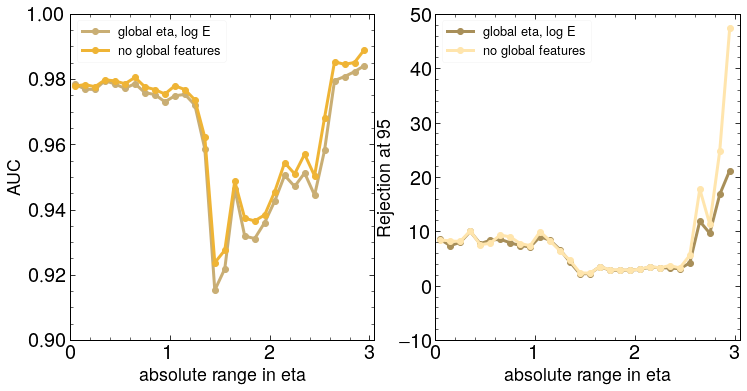

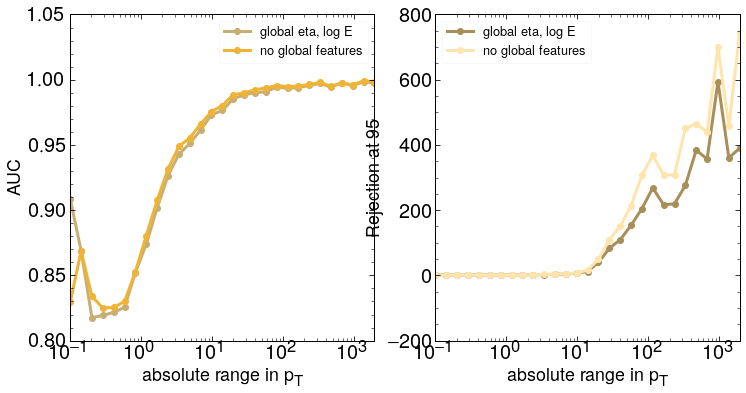

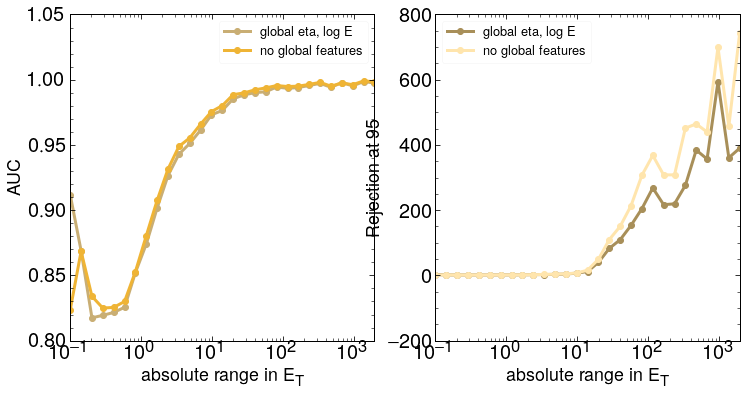

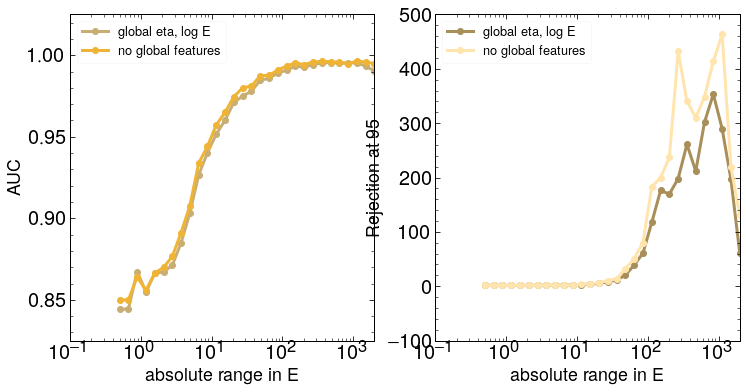

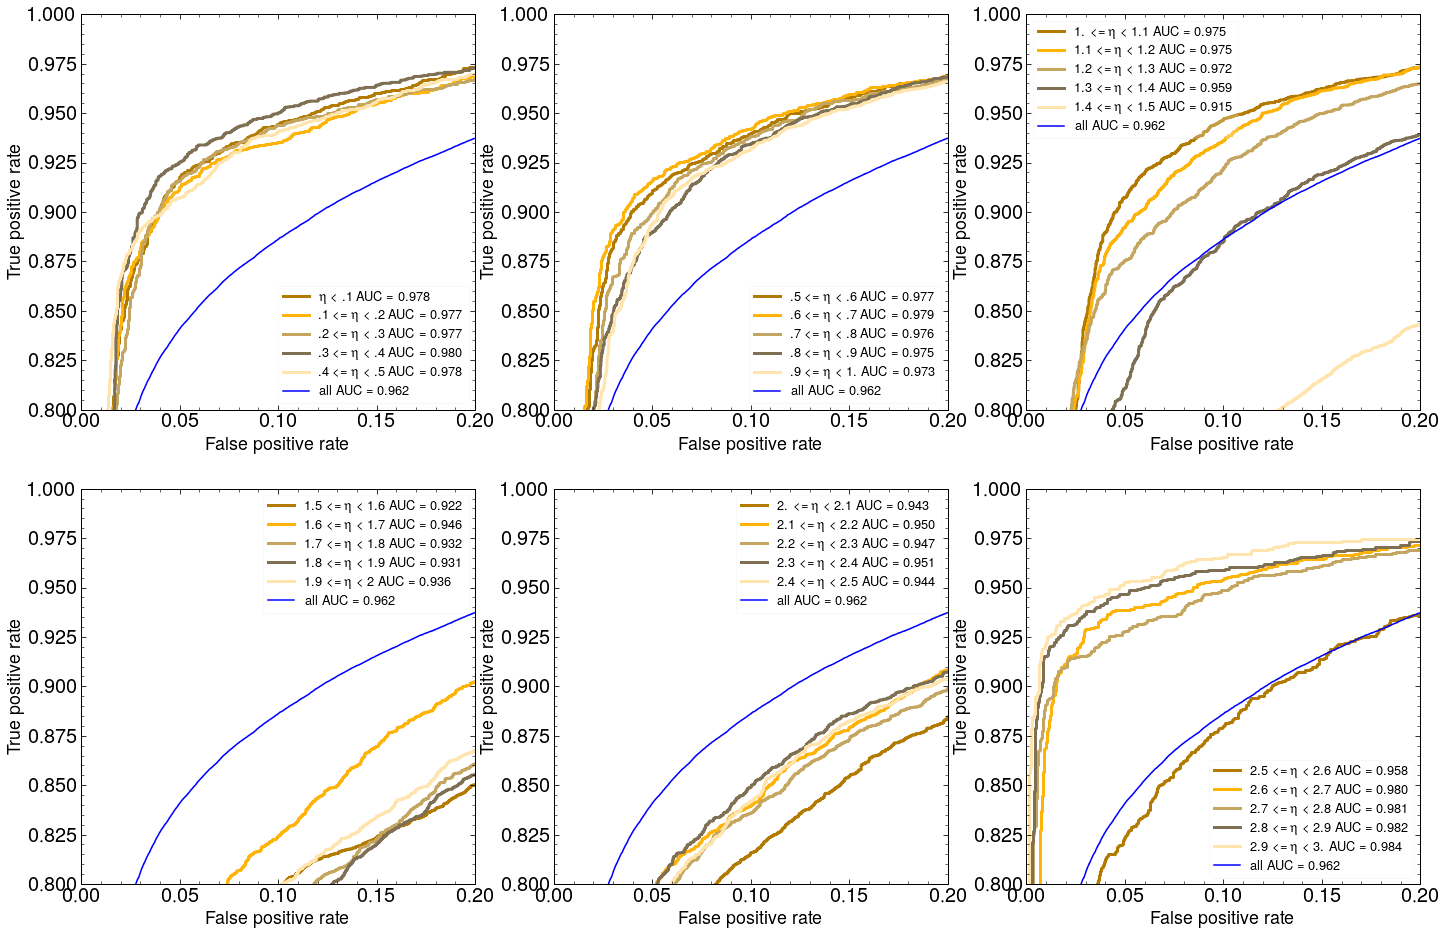

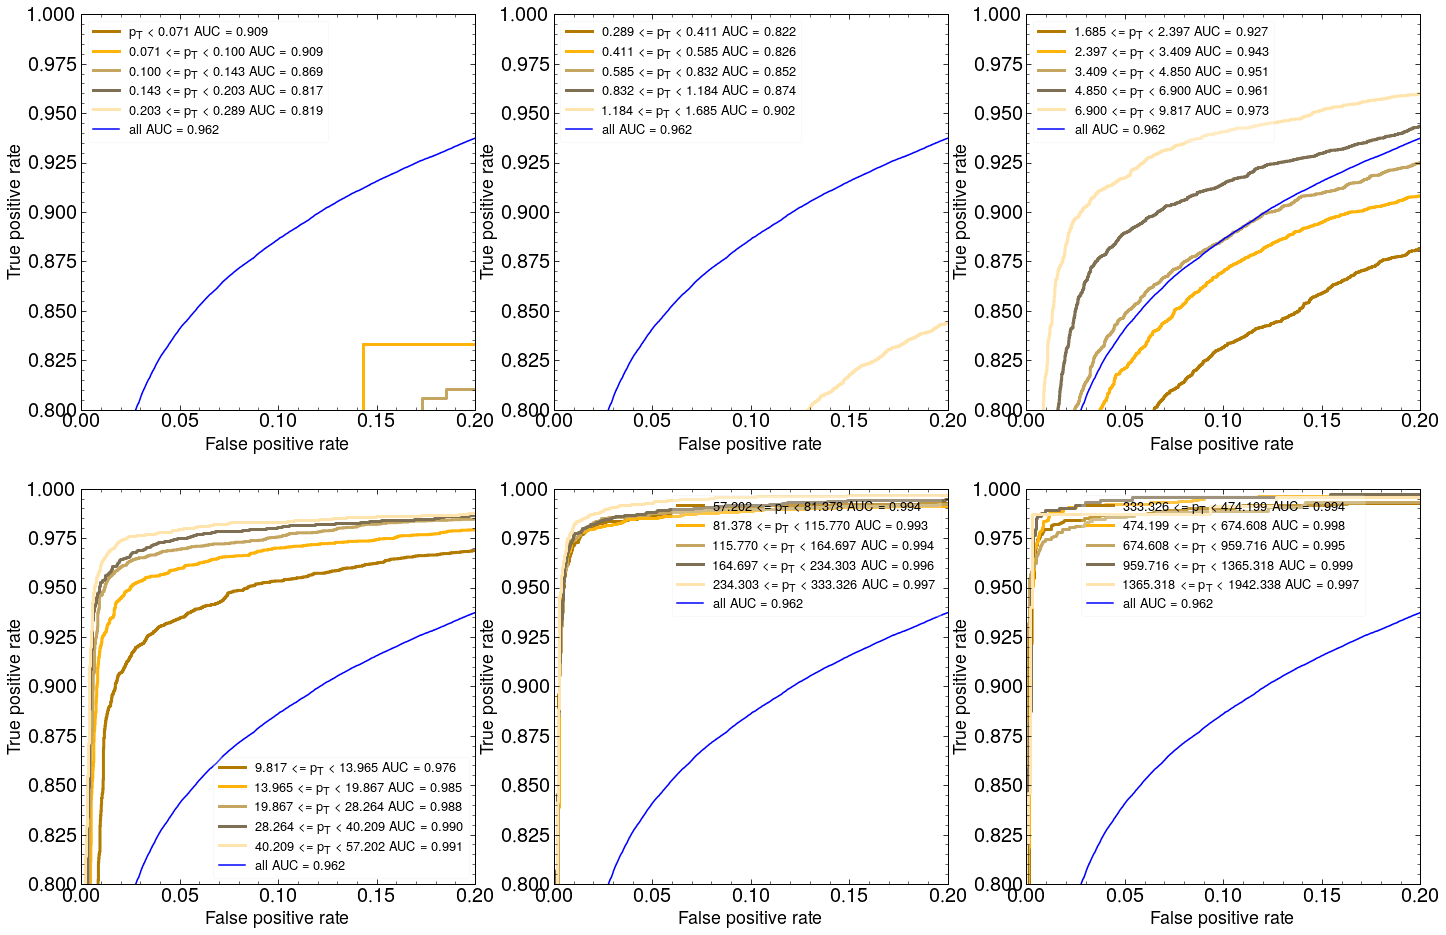

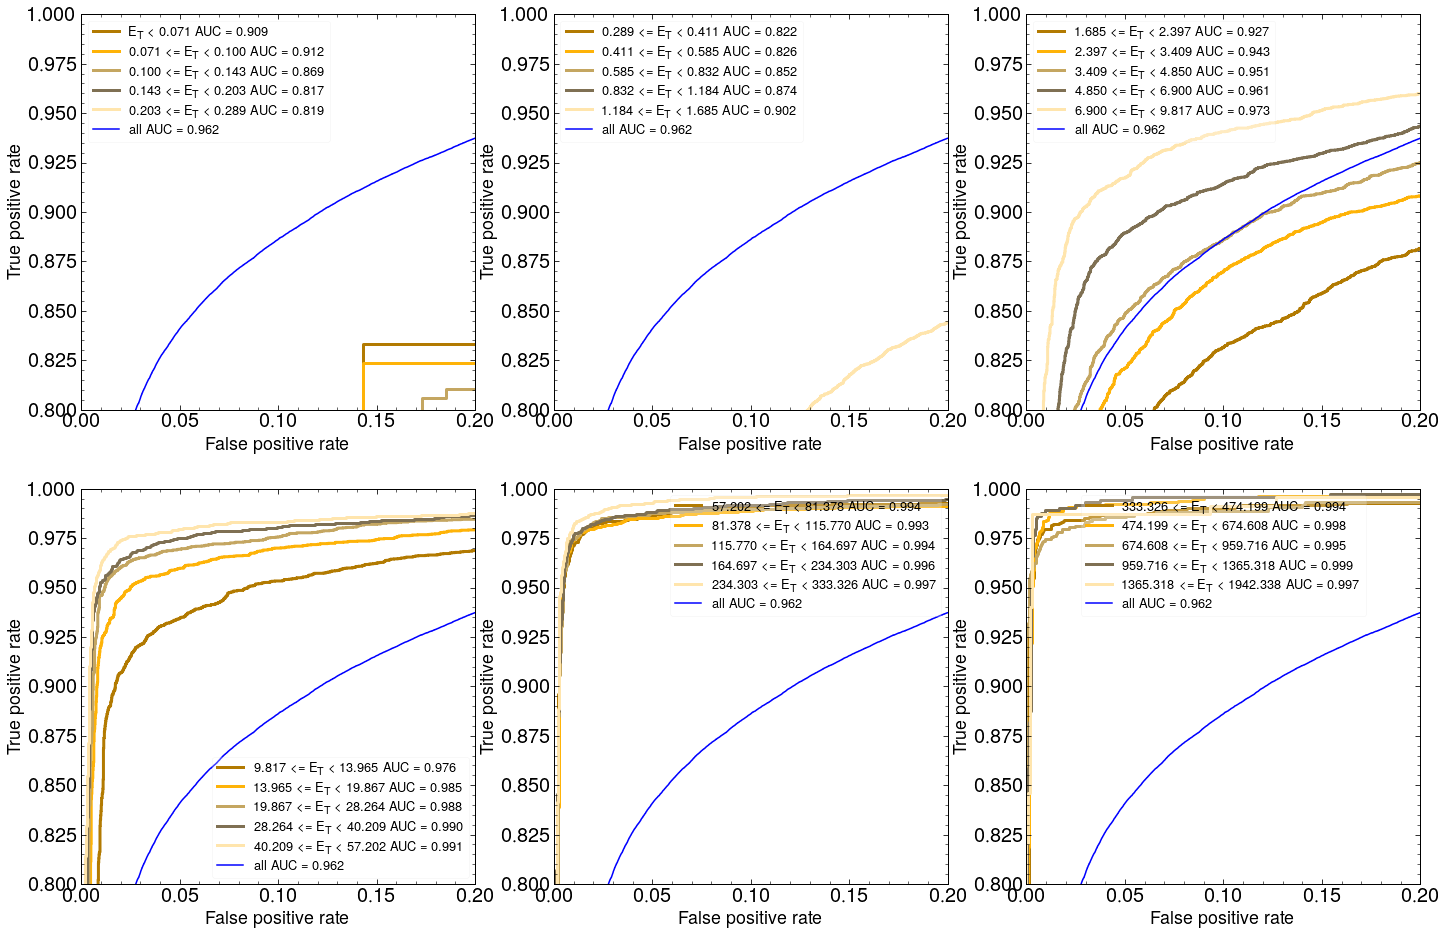

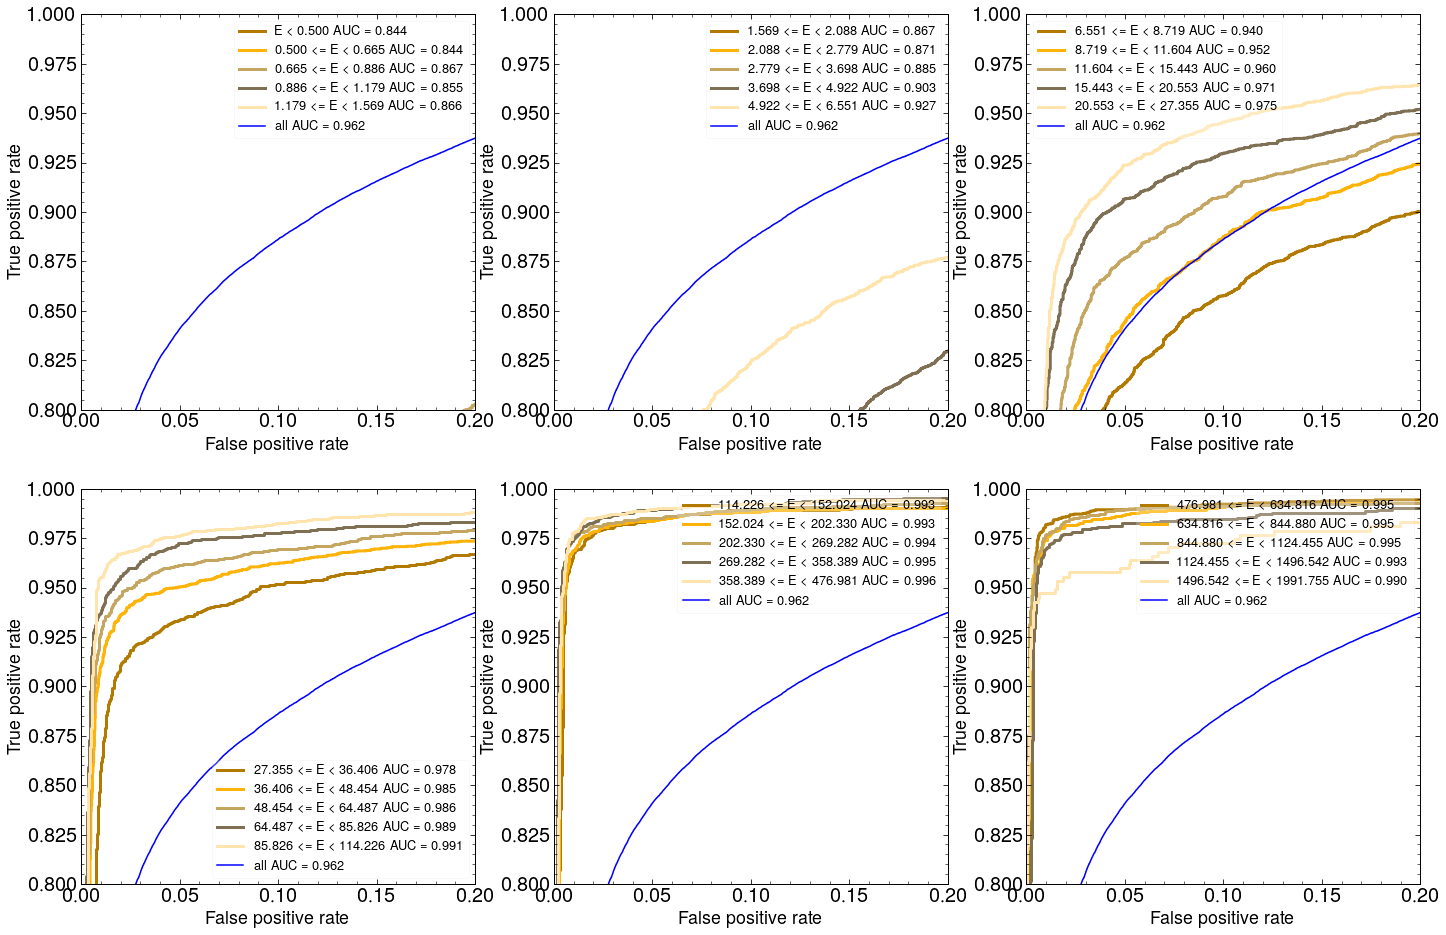

In [30]:
#with F = 300
plots1(eta_ranges[:-1], auc_LEBF3_eta[:-1], auc_ng_eta[:-1], reg95_LEBF3_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, log E')
plots1(Pt_range, auc_LEBF3_pt[:-1], auc_ng_pt[:-1], reg95_LEBF3_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, log E', logx=True)
plots1(ET_range, auc_LEBF3_ET[:-1], auc_ng_ET[:-1], reg95_LEBF3_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, log E', logx=True)
plots1(E_range, auc_LEBF3_E[:-1], auc_ng_E[:-1], reg95_LEBF3_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, log E', logx=True)

AUCplot(eta_ranges, fps_LEBF3_eta, tps_LEBF3_eta, auc_LEBF3_eta, rangetype='eta')
AUCplot(Pt_range, fps_LEBF3_pt, tps_LEBF3_pt, auc_LEBF3_pt, rangetype='Pt')
AUCplot(ET_range, fps_LEBF3_ET, tps_LEBF3_ET, auc_LEBF3_ET, rangetype='E_T')
AUCplot(E_range, fps_LEBF3_E, tps_LEBF3_E, auc_LEBF3_E, rangetype='E')

<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0., max(ranges)+.1)
<ipython-input-11-c0d29c55a856>:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid

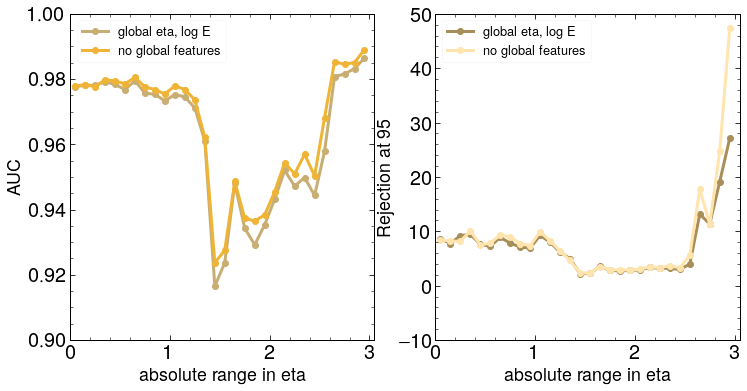

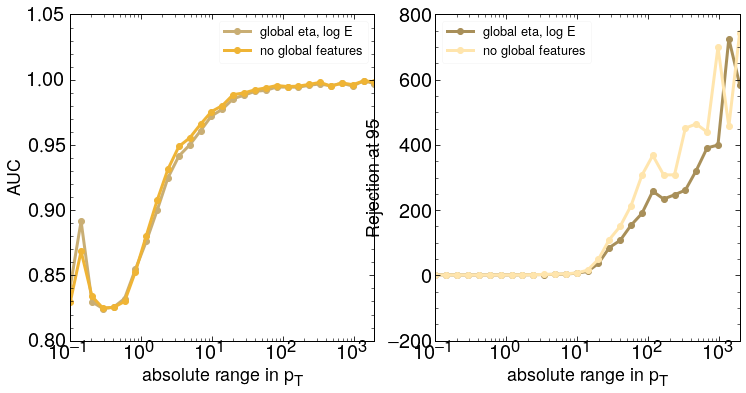

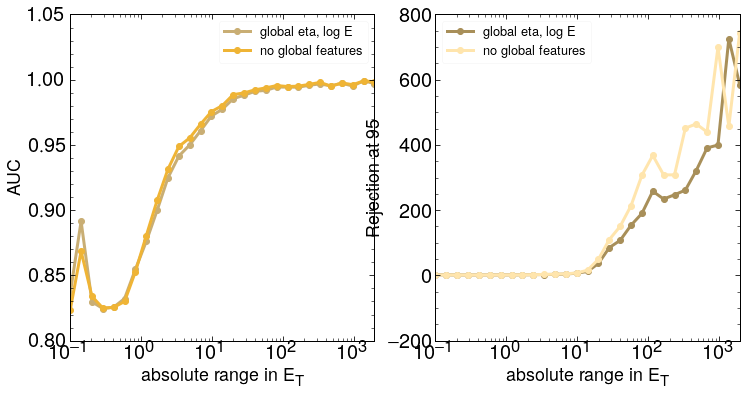

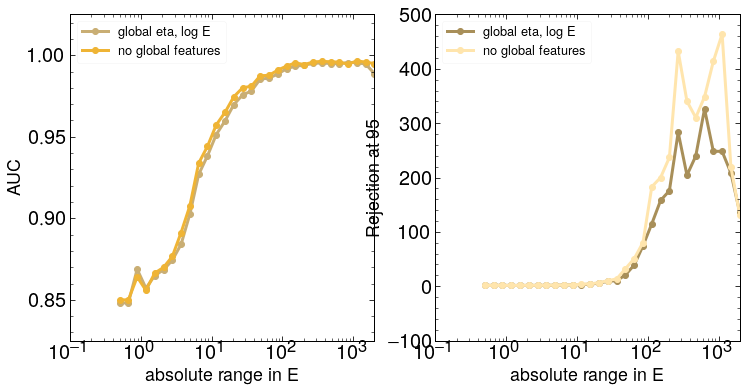

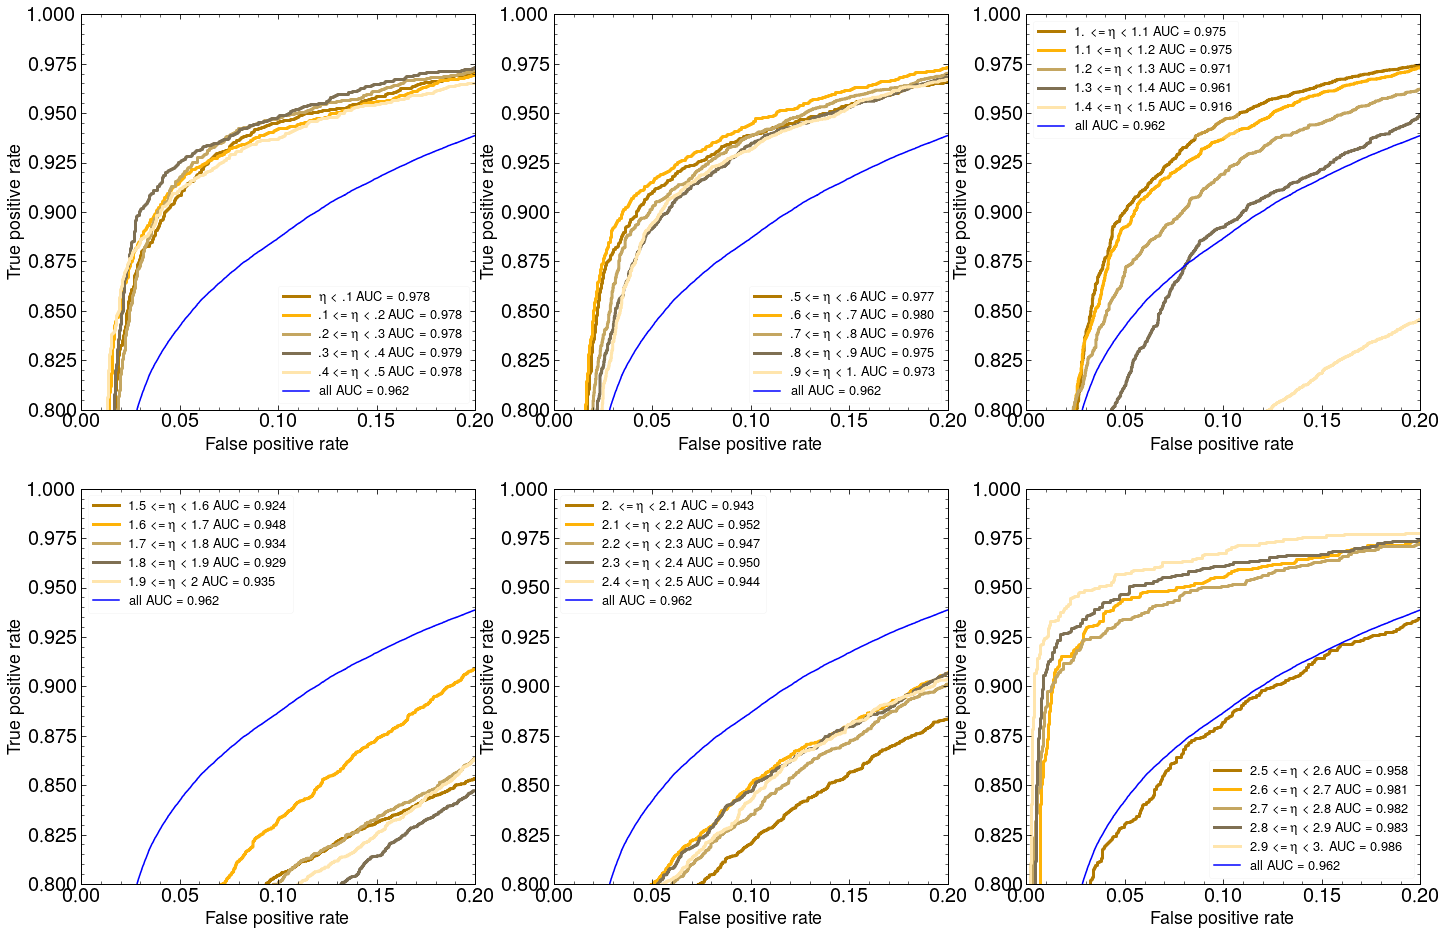

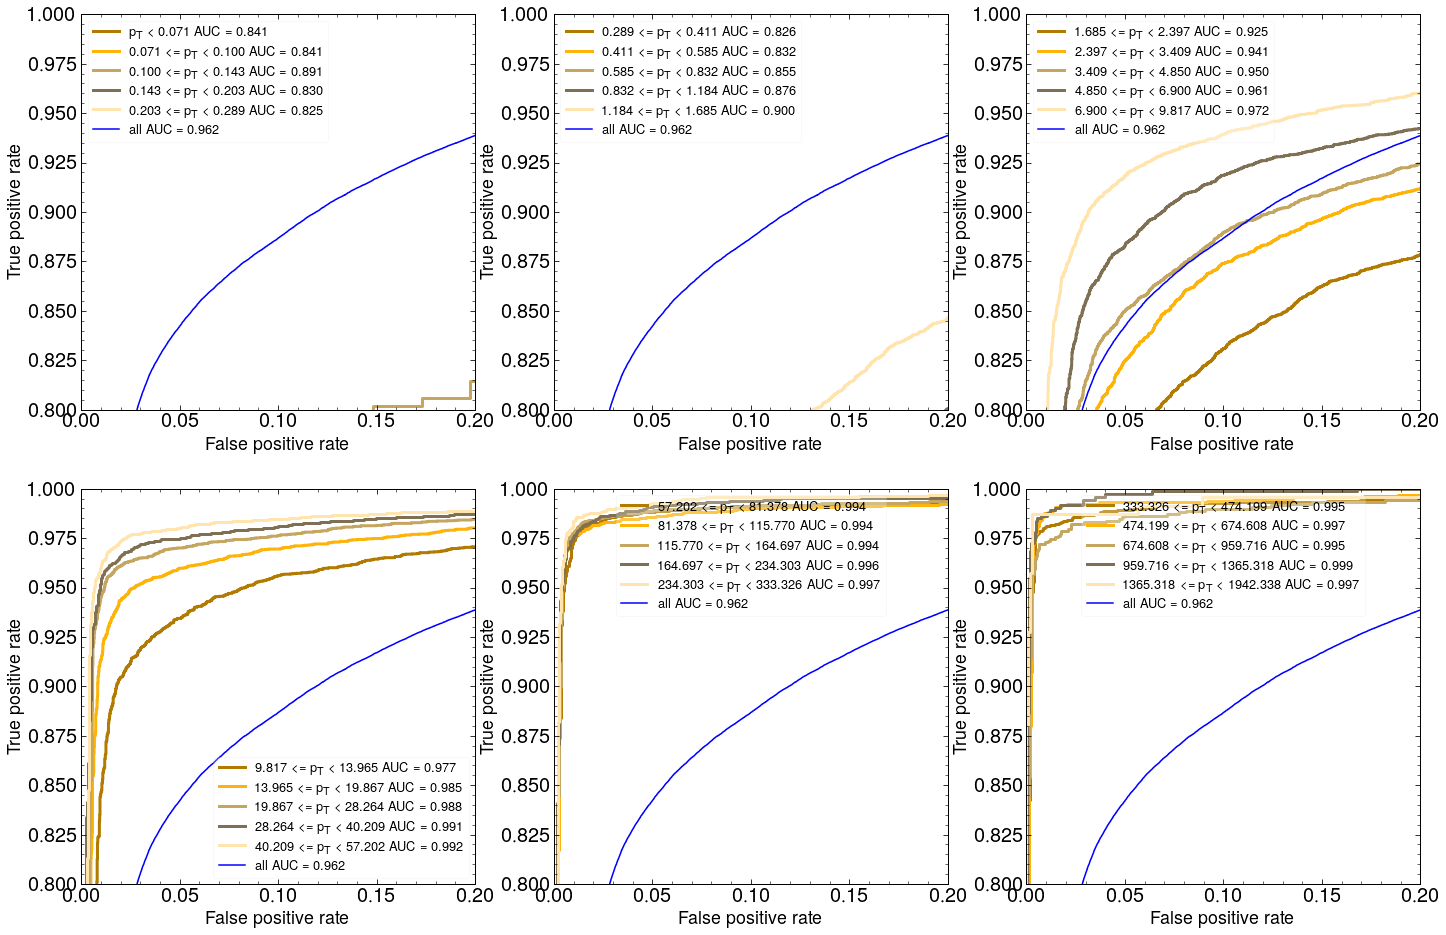

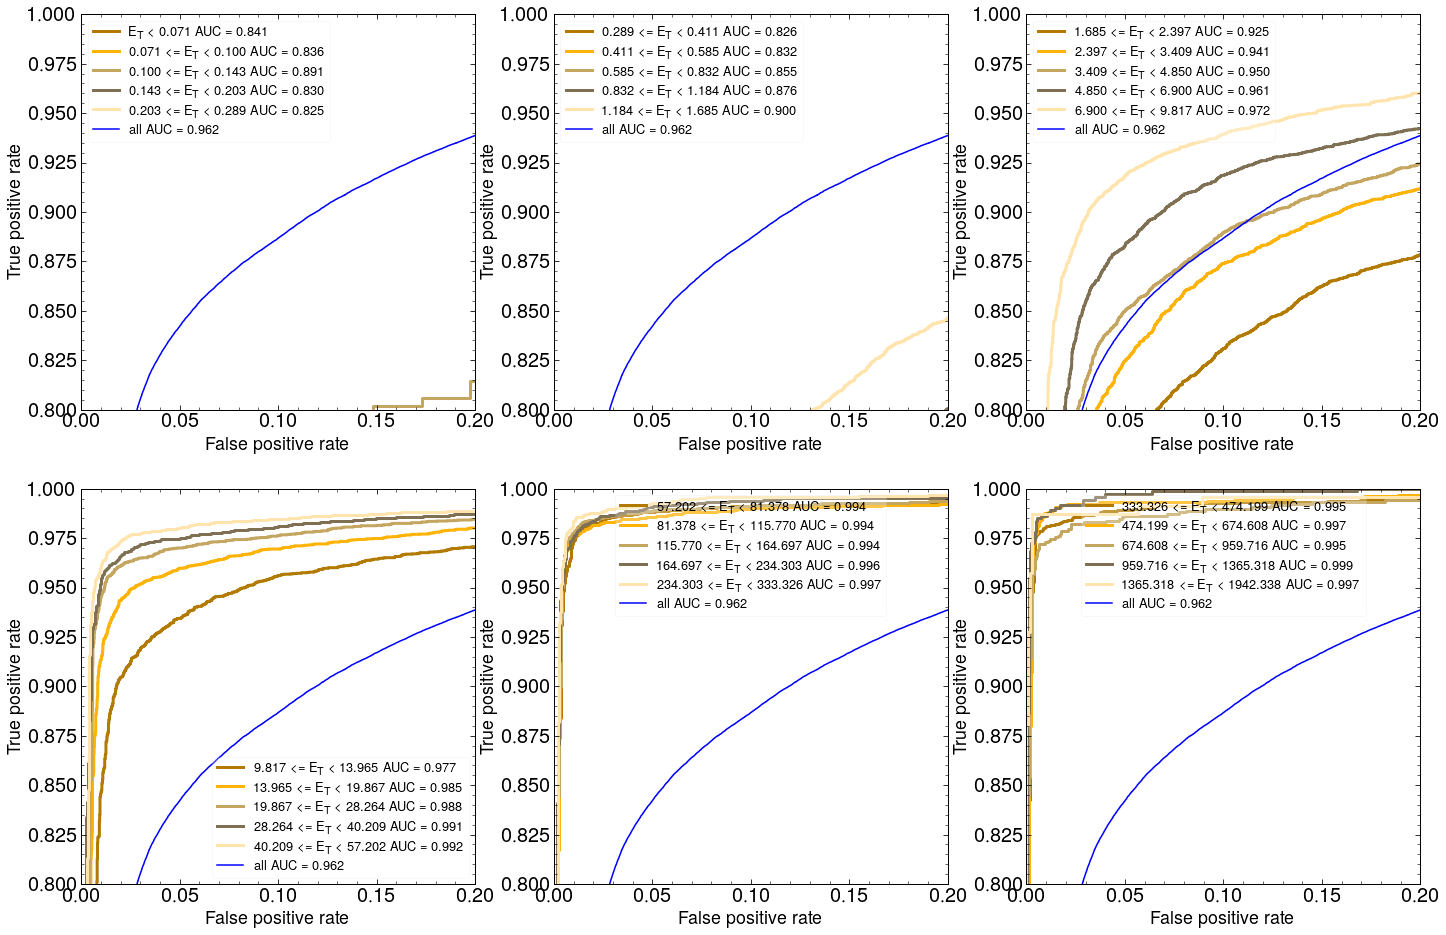

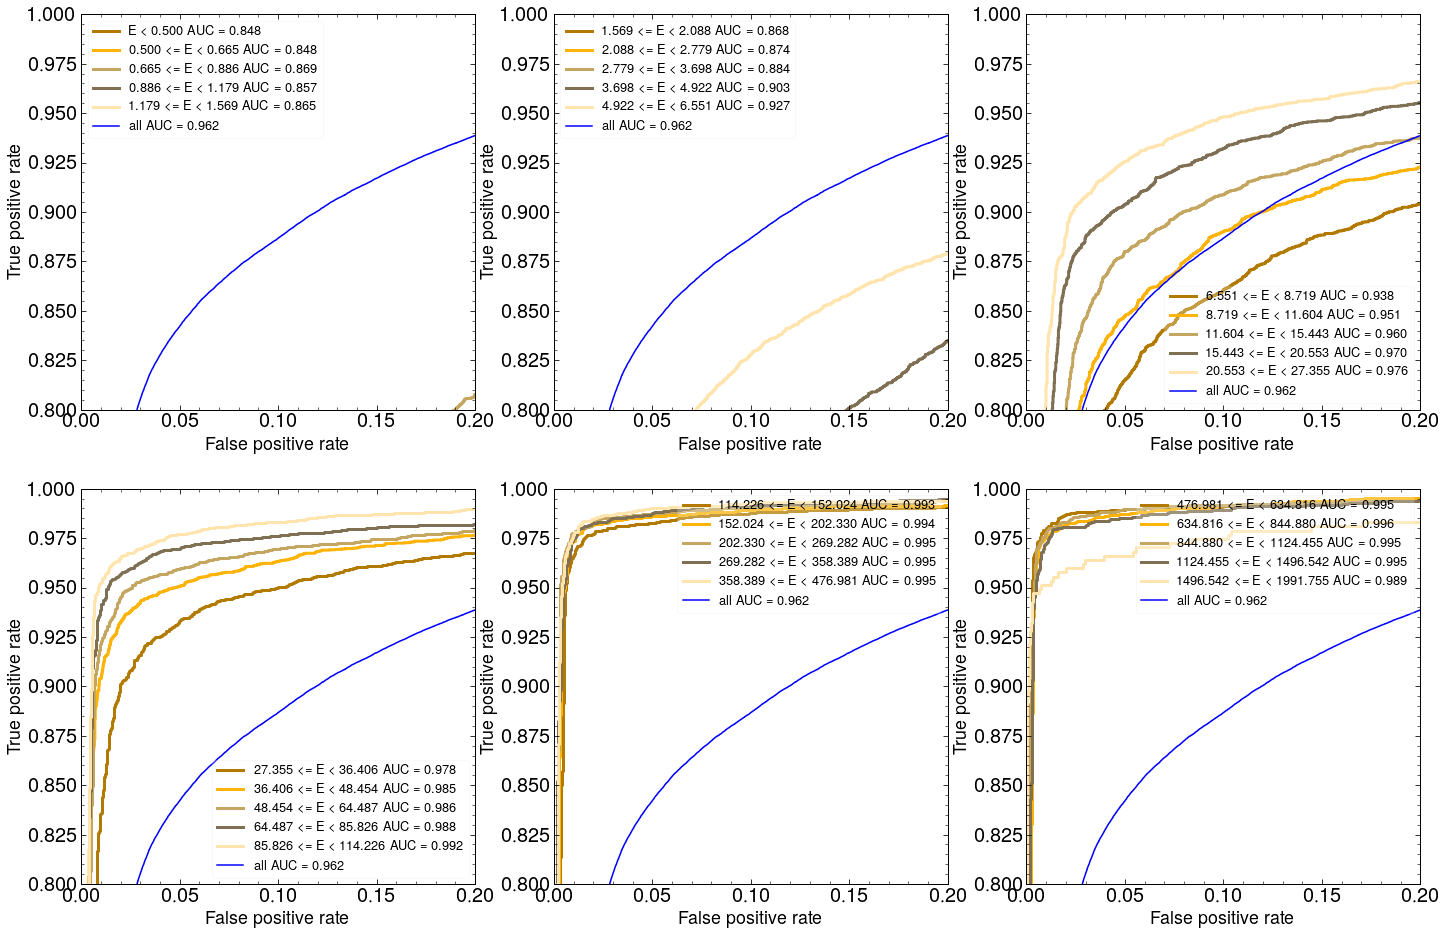

In [31]:
#with F = 400
plots1(eta_ranges[:-1], auc_LEBF4_eta[:-1], auc_ng_eta[:-1], reg95_LEBF4_eta[:-1], reg95_ng_eta[:-1], rangename='eta', globalpars='eta, log E')
plots1(Pt_range, auc_LEBF4_pt[:-1], auc_ng_pt[:-1], reg95_LEBF4_Pt[:-1], reg95_ng_Pt[:-1], rangename='$p_T$', globalpars='eta, log E', logx=True)
plots1(ET_range, auc_LEBF4_ET[:-1], auc_ng_ET[:-1], reg95_LEBF4_ET[:-1], reg95_ng_ET[:-1], rangename='$E_T$', globalpars='eta, log E', logx=True)
plots1(E_range, auc_LEBF4_E[:-1], auc_ng_E[:-1], reg95_LEBF4_E[:-1], reg95_ng_E[:-1], rangename='E', globalpars='eta, log E', logx=True)

AUCplot(eta_ranges, fps_LEBF4_eta, tps_LEBF4_eta, auc_LEBF4_eta, rangetype='eta')
AUCplot(Pt_range, fps_LEBF4_pt, tps_LEBF4_pt, auc_LEBF4_pt, rangetype='Pt')
AUCplot(ET_range, fps_LEBF4_ET, tps_LEBF4_ET, auc_LEBF4_ET, rangetype='E_T')
AUCplot(E_range, fps_LEBF4_E, tps_LEBF4_E, auc_LEBF4_E, rangetype='E')